# Imports and path

In [109]:
import rdkit
import sys
import re
import os

path = os.getcwd()
project_dir = re.sub(r"\\molecules\\notebooks", "", path)
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
from typing import List, Dict, Any, Tuple
from tqdm.notebook import tqdm, trange
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool
from torch_geometric.utils.smiles import from_smiles
from torch_geometric.data import DataLoader, Batch
from molecules.src.compound_spaces import SmallZINC
from molecules.src.organic import show_molecules
from selfies import encoder, decoder
from src.mutate import mutate_selfie
from src.al_loop import LeadCompound, Loop
from src.organic import evaluate_synthesizability
from src.sas_score import compute_ertl_score
from src.server_wrapper import FlaskAppClient
from sklearn.ensemble import RandomForestClassifier
from rich.console import Console
import itertools
import copy

console = Console()

# Global variables

In [110]:
SERVER_URL = "http://127.0.0.1:5000"
YOUR_TOKEN = "29ee9860-387c-4302-abfc-ef70cbb09c81"

# Start

In [114]:
# 1. Sample random compounds from the ZINC dataset

np.random.seed(42)

budget = 1000
library = SmallZINC()
candidates = library.sample(budget)
candidates_smiles = [rdkit.Chem.MolToSmiles(mol) for mol in candidates]
show_molecules(candidates)

Found local copy...
Loading...
Done!


MolGridWidget()

### The cell below requires the server to be started

In [115]:
# Request running HTS on the selected compounds

loop = Loop(base_dir=".", user_token=YOUR_TOKEN, target="GSK3β_server")
client = FlaskAppClient(base_url=SERVER_URL)

tested_molecules = loop.test_in_lab_and_save([LeadCompound(smiles=s) for s in set(candidates_smiles)], client=client)

[13:15:19] Saving results to ..                                                                       ]8;id=577724;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=807197;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#44\44]8;;\

[13:16:19] Saving results to 14.json.                                                                ]8;id=714002;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=813289;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

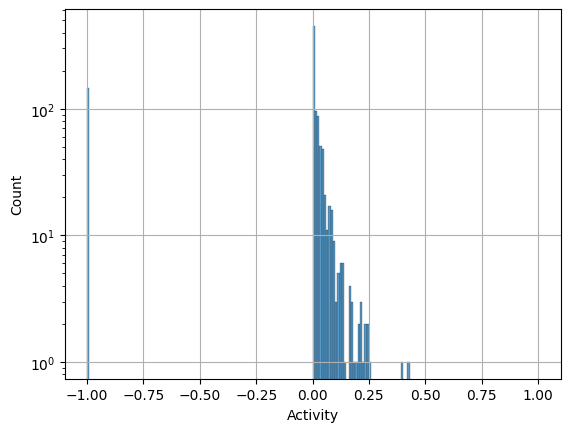

In [116]:
# Show the summary of the screening results

data = pd.DataFrame({'Activity': [mol.activity for mol in tested_molecules]})
sns.histplot(data, binrange=(-1, 1), binwidth=0.01, x='Activity', log=True) # -1 corresponds to nonsynthesizable compounds
plt.grid()
plt.show()

# Define graph featurizer used with pytorch geometric

In [201]:
# Based on https://pytorch-geometric.readthedocs.io/en/2.5.2/_modules/torch_geometric/utils/smiles.html

def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise ValueError("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


e_map: Dict[str, List[Any]] = {
    'bond_type': [
        'UNSPECIFIED',
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'QUADRUPLE',
        'QUINTUPLE',
        'HEXTUPLE',
        'ONEANDAHALF',
        'TWOANDAHALF',
        'THREEANDAHALF',
        'FOURANDAHALF',
        'FIVEANDAHALF',
        'AROMATIC',
        'IONIC',
        'HYDROGEN',
        'THREECENTER',
        'DATIVEONE',
        'DATIVE',
        'DATIVEL',
        'DATIVER',
        'OTHER',
        'ZERO',
    ],
    'stereo': [
        'STEREONONE',
        'STEREOANY',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
    ],
    'is_conjugated': [False, True],
}


def from_lead_compound(compound: LeadCompound, with_hydrogen: bool = False,
                kekulize: bool = False) -> 'torch_geometric.data.Data':
    r"""Converts a LeadCompound to a :class:`torch_geometric.data.Data`
    instance.

    Args:
        compound (LeadCompound): The LeadCompound object.
        with_hydrogen (bool, optional): If set to :obj:`True`, will store
            hydrogens in the molecule graph. (default: :obj:`False`)
        kekulize (bool, optional): If set to :obj:`True`, converts aromatic
            bonds to single/double bonds. (default: :obj:`False`)
    """
    from rdkit import Chem, RDLogger

    from torch_geometric.data import Data

    RDLogger.DisableLog('rdApp.*')

    smiles = compound.smiles
    mol = Chem.MolFromSmiles(smiles)
    y = compound.activity

    if y is None:
        y = -1.0 # set any value so that new compounds will be parsed

    if mol is None:
        mol = Chem.MolFromSmiles('')
    if with_hydrogen:
        mol = Chem.AddHs(mol)
    if kekulize:
        Chem.Kekulize(mol)
    
    X = []
    for atom in mol.GetAtoms():
        attributes = []
        attributes += one_of_k_encoding_unk(
            atom.GetSymbol(),
            ['C', 'O', 'N', 'Cl', 'F', 'S', ''])
        attributes += one_of_k_encoding_unk(
            atom.GetAtomicNum(), 
            [5, 6, 7, 8, 9, 15, 16, 17, 35, 53, 0])
        attributes += one_of_k_encoding(
            len(atom.GetNeighbors()),
            [0, 1, 2, 3, 4, 5])
        attributes += one_of_k_encoding(
            atom.GetTotalNumHs(),
            [0, 1, 2, 3, 4])
        attributes.append(atom.GetFormalCharge())
        attributes.append(atom.IsInRing())
        attributes.append(atom.GetIsAromatic())
        attributes.append(atom.GetExplicitValence())
        attributes.append(atom.GetNumRadicalElectrons())
        attributes = np.array(attributes).astype(float)
        X.append(attributes)
        
    X = np.stack(X)
    x = torch.tensor(X, dtype=torch.float32)

    edge_indices, edge_attrs, edge_weights = [], [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        val = mol.GetBondBetweenAtoms(i, j).GetBondTypeAsDouble()

        e = []
        e.append(e_map['bond_type'].index(str(bond.GetBondType())))
        e.append(e_map['stereo'].index(str(bond.GetStereo())))
        e.append(e_map['is_conjugated'].index(bond.GetIsConjugated()))

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]
        edge_weights += [val, val]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float32).view(-1, 3)
    edge_weight = torch.tensor(edge_weights, dtype=torch.float32).view(-1, 1)

    if edge_index.numel() > 0:  # Sort indices.
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr, edge_weight = edge_index[:, perm], edge_attr[perm] , edge_weight[perm]

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles, y=y, edge_weight=edge_weight)

# GNN model class - using GCN layers

In [118]:
class GraphNeuralNetwork(torch.nn.Module):

    def __init__(self, model_dim: List[int],
                 dropout_rate: List[float],
                 input_dim: int = 100, 
                 output_dim: int = 1, 
                 concat_max_pooling: bool = False,):

        assert len(model_dim) == len(dropout_rate), f'Specified {len(model_dim)} convolutional layers, but {len(dropout_rate)} dropout rates '

        super().__init__()
        
        self.model_dim = model_dim
        self.layers_num = len(model_dim)
        self.dropout_rate = dropout_rate
        self.concat_max_pooling = concat_max_pooling
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.conv_layers = [GCNConv(in_channels=input_dim,
                                    out_channels=self.model_dim[0])] + \
                            [GCNConv(in_channels=self.model_dim[i],
                                    out_channels=self.model_dim[i+1])
                            for i in range(0, self.layers_num-1)]

        self.drop_layers = [torch.nn.Dropout(p = self.dropout_rate[j])
                            for j in range(len(self.conv_layers))]

        self.batch_norms = [torch.nn.BatchNorm1d(num_features=self.model_dim[j])
                            for j in range(len(self.conv_layers))]

        self.conv_layers = torch.nn.ModuleList(self.conv_layers)
        self.drop_layers = torch.nn.ModuleList(self.drop_layers)

        self.out_layer = torch.nn.Linear(2*model_dim[-1], output_dim) if self.concat_max_pooling \
                        else torch.nn.Linear(model_dim[-1], output_dim)


    def forward(self, data: Batch) -> torch.Tensor:
        # NOTE: GCNs do not use edge_attributes, which may be used in some other GNN layers

        # Prepare the data
        x, edge_index, edge_weight, edge_attr = (data.x).type(torch.FloatTensor), data.edge_index, data.edge_weight, data.edge_attr
        x, edge_index, edge_weight, edge_attr = x.to(self.device), edge_index.to(self.device), edge_weight.to(self.device), edge_attr.to(self.device)

        # Apply convolutional layers
        for i in range(len(self.conv_layers)):   
            x = self.conv_layers[i](x, edge_index, edge_weight)
            x = self.batch_norms[i](x)
            x = self.drop_layers[i](x)
            x = F.relu(x, inplace=False)

        # Apply mean pooling
        _x = x
        x = global_mean_pool(x, data.batch)

        # Concatenate max pooling
        if self.concat_max_pooling:
            _x = global_max_pool(_x, data.batch)
            x = torch.cat([x, _x], dim=-1)

        # Apply final linear layer
        x = self.out_layer(x)

        return x

# GAT model definition

In [119]:
# Code based on https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gat.py

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1,
                             concat=False, dropout=0.6)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    def forward(self, data):
        x, edge_index, edge_attr = (data.x).type(torch.FloatTensor), data.edge_index, data.edge_attr
        x, edge_index, edge_attr = x.to(self.device), edge_index.to(self.device), edge_attr.to(self.device)
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = global_mean_pool(x, data.batch)
        return x

# Random and Mutate Loops definitions

In [249]:
# Implement active learning loop that mutates compounds and filters the candidates using ML predictive models

# Let's define a running function
def run(loop, budget=1000, purge=False, steps=10):
    target = loop.target
    user_token = loop.user_token

    if purge:
        shutil.rmtree(loop.base_dir, ignore_errors=True)

    os.makedirs(loop.base_dir, exist_ok=True)

    if target == "GSK3β":
        client = None
    else:
        client = FlaskAppClient(SERVER_URL)

    if loop.n_iterations > 0:
        raise ValueError(f"Already run. Please remove the folder {loop.base_dir} to run again.")

    metrics = []
    all_result: List[LeadCompound] = []
    budget_per_step = budget // steps
    assert budget % steps == 0 # for simplicity
    for step in range(steps):
        console.print(f"[red]Step {step}[/red]")
        candidates = loop.propose_candidates(budget_per_step)
        loop.test_in_lab_and_save(candidates, client=client)
        result: List[LeadCompound] = loop.load(iteration_id=step)
        all_result += result
        loop.generate_visualization(iteration_id=step)
        all_result_sorted = sorted(all_result, key=lambda x: x.activity, reverse=True)
        metrics.append({"top10": np.mean([x.activity for x in all_result_sorted[:10]]),
                        "top10_synth": np.mean([x.synth_score for x in all_result_sorted[:10]])})

    return metrics

class RandomLoop(Loop):
    """Samples random compounds from the ZINC database."""
    def __init__(self, base_dir: Path, user_token=None, target="GSK3β_server"):
        self.space = SmallZINC()
        super().__init__(base_dir, user_token, target)
        
    def propose_candidates(self, n_candidates: int) -> List[LeadCompound]:
        candidates = self.space.sample(n_candidates)
        smi = set([rdkit.Chem.MolToSmiles(mol) for mol in candidates])

        return [
            LeadCompound(s, None, None) for s in smi
        ]

# 4. Implement mutation loop

class MutateLoop(Loop):
    """Implementation of AL algorithm that mutates top compounds from the previous iterations.

       Mutate loop should first search random and then mutate top compounds
    """
    def __init__(self, base_dir: Path, n_warmup_iterations: int = 1, mutate_top_k: int = 10, user_token=None, target="DRD2"):
        self.space = SmallZINC()
        self.n_warmup_iterations = n_warmup_iterations
        self.mutate_top_k = mutate_top_k
        super().__init__(base_dir, user_token, target)

    def _propose_random(self, n_candidates: int) -> List[LeadCompound]:
        smi = [self.space.try_sample()[0] for _ in range(n_candidates)]
        return [
            LeadCompound(s, None, None) for s in smi
        ]

    def propose_candidates(self, n_candidates: int) -> List[LeadCompound]:

        if n_candidates < self.mutate_top_k:
            raise ValueError(f"n_candidates must be at least mutate_top_k ({self.mutate_top_k}).")

        if n_candidates == 0:
            return []

        if self.n_iterations < self.n_warmup_iterations:
            return self._propose_random(n_candidates)

        previous_results: List[LeadCompound] = self.load()
        candidates = list(sorted(previous_results, key = lambda m: (-m.activity, -m.synth_score)))
        selfies = [encoder(m.smiles) for m in candidates[:self.mutate_top_k]]

        new_compounds = []
        while len(set(new_compounds)) < n_candidates:
            for selfie in selfies:
                new_selfie = decoder(mutate_selfie(selfie, max_molecules_len=100)[0])
                if compute_ertl_score(new_selfie) > 1. and compute_ertl_score(new_selfie) < 4.:
                    new_compounds.append(new_selfie)
                if len(set(new_compounds)) == n_candidates:
                    break

        new_compounds = set(new_compounds)

        assert len(new_compounds) == n_candidates
        return [LeadCompound(smiles=c) for c in new_compounds]

# Run the Mutate Loop to get data which will be more suitable for GNN training

In [121]:
# 5. Run mutation loop
mloop = MutateLoop(base_dir="mutate", user_token=YOUR_TOKEN, target="GSK3β_server")
mutate_metrics = run(mloop, purge=True, budget=1000, steps=10)

mutate_cmpds = sum([mloop.load(iteration_id=i) for i in range(mloop.n_iterations)], [])

Found local copy...
Loading...
Done!


[13:16:55] Saving results to mutate.                                                                  ]8;id=683952;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=614821;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#44\44]8;;\

Step 0

[13:17:04] Saving results to mutate\0.json.                                                          ]8;id=527615;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=221120;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_0.html for 100 compounds from iteration 0.        ]8;id=486359;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=581753;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['CCOc1ccc(CCC(=O)N2CCc3ccc(Cl)cc3C2)cc1', 'Cc1ccc(Oc2ccc(N)c(C(F)(F)F)c2)cc1C', 'O=C(Cc1ccc(CNC(=O)c2cnc3c(c2)NC(=O)CO3)cc1)Nc1ccccc1F', 'CCn1cc(C(=O)Nc2cc(C)nn2-c2ccccc2C(F)(F)F)cn1', 'Cc1ccc(C(=O)N(C)[C@@H](C)c2cccnc2)c(C)n1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'CC[C@@H](C)n1ncc2c(C(=O)N3CCC(c4noc(C)n4)CC3)cc(C)nc21', 'CC(=O)N1C=Cc2ccccc2[C@@H]1CC(=O)N1CCN(S(=O)(=O)c2ccc(C)cc2)CC1', 'Cc1cnn(C)c1C(=O)/N=c1/sc2c(C)ccc(C)c2n1C', 'O=S(=O)(c1ccc(F)cc1F)N1CCC(O)(C(F)(F)F)CC1', 'Cc1cccc(CN(C2CC2)S(=O)(=O)c2ccc3c(c2)C(=O)N(C)C3=O)c1', 'CCn1cnnc1CNC(=O)c1cccc(F)c1Cl', 'Cc1c(C#N)c2ccccc2n1CC(=O)N1CC[C@H](O)C[C@@H]1C(=O)[O-]', 'O=C(NNC(=O)c1cc(F)cc(F)c1)c1cccc(O)c1', 'O=C(NNC(=O)[C@H]1[C@@H](C(=O)[O-])[C@H]2CC[C@@H]1C2)c1cccc(Cl)c1', 'C[C@@H](NC(=O)CN(C)c1ccccc1)c1ccccc1Cl', 'CC[C@@H](O)CN(Cc1cccc(C(=O)N(C)C)c1)c1ccccc1', 'Cc1ccccc1CN1CC[NH+](CC(=O)Nc2cccc3nonc23)CC1', '[O-]C1=NC(=S)S/C1=C\\c1ccc(CSC(F)F)o1', 'O=C(c1cn(C2CCN(S(=O)(=O)c3c(F)cccc3F)CC2)nn1)N1CCCCC1', 'COCC[NH+]1CCc2nc(S

MolGridWidget()

Step 1

[13:17:13] Saving results to mutate\1.json.                                                          ]8;id=614465;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=612131;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_1.html for 100 compounds from iteration 1.        ]8;id=713147;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=724091;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC[N-1]C)C=C1OC', 'NC=CC=C(C1=C(F)C=C(F)C=C1)F', 'CCCOCC(=O)N(C)CC=C(C1=CC=C(OC)C=C1)[NH1]N', 'PC1=CC=C(C2=C(F)C=C(F)C=C2F)C=N1', 'CCCOCC(=O)N(C)CC1=C(C2=CC=C(OC)C=C2)[NH1]NO1', 'CC1=CC=CC=2C(CCNC(=O)N[C@@H1](CO)C3=CC=CC=C3Br)=C[NH1]C1=2', 'O=C(NC[C@H1]1CC2=CC=CC(C3=CN=CN=C3)=C2O1)CC=CC=C(Cl)C=C', 'N1C=CC=C(C2=C(F)C=C(F)C=N2)C=N1', 'COC1=CC=C(C(=O)C=2S#[S+1]3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'C[S-1]COC1=NC=NC(NC2=CC(Cl)=CC(Cl)=C2)=C1N', '[S+1]CCCOCC(=O)N(C)C=1C=C(C2=CC=C(OC)C=C2)[NH1]N=1', 'C1C=CC=2C(CCNC(=O)N[C@@H1](CO)C3=CC=CC=C3F)=C[NH1]C1=2', 'CCCOC1=NC=NC(NC2=CC(Cl)=CC(Cl)=C2)=C1[B+1]N', 'BC1=CC=CC=2C(CCNC(=O)N[C@@H1](CO)C3=CC=CC=C3F)=C[NH1]C1=2', 'CC=CC=CCC(CCNC(=O)N[C@@H1](CO)C1=CC=CC=C1[H])F', 'CCCONC(=O)N(C)C=1C=C(C2=CC=C(OC)C=C2)[NH1]N=1', 'CCCOCC(=O)N(C)CC=1C=C(C2=CC=C(OC)C=C2)[NH1]N=1', 'CC1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'C[C@H1](NC(=O)/C=C1/SC2=CC=CC=C2NC1=O)C3=CC=CC=C3', 'CC=CC#N', 'O=C(NC#[C@

MolGridWidget()

Step 2

[13:17:27] Saving results to mutate\2.json.                                                          ]8;id=900090;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=608223;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_2.html for 100 compounds from iteration 2.        ]8;id=896005;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=797876;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['C1OC=CC=C1C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4', 'COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)Cl', 'NC=CC=CCCF', 'NCI', 'BC1=CC=C(C2=C(F)C=C(F)C=C2F)C=N1', 'NC1=CC=C(C2=C(F)C=C([P-1])C=C2I)C=N1', 'BNC1=CC=C(C2=C(F)C=C(F)C=C2F)C=N1', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)SCC)C=COC', 'COC=CC1=C(C(=O)CC=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC[N-1])CC=C1OC', 'C=1OC=CN=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1O[P+1]', 'NC1=CC=C(C2=C(F)C=C(S)C=C2F)C=N1', 'NC1=CB=C(C2=C(F)C=C(F)C=C2F)C=N1', 'NC=C1C=C(C2=C(F)C=C(F)C=C2F)C=NN1', 'COC=C=[S+1]C=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)COC', 'C1OP=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'NC1=CC=C(C2=C(F)C=C([H])C=C2F)C=N1', 'N1C=CC=C(C=C(F)C=C1F)F', 'NC[H]', 'C1OC=C1', 'CC=1OC=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=1OC', '[P+1]CCCC1=CC=C([C@H1]2C(C#N)=C(N)OC3=N[NH1]C(C)=C32)S1', 'COC=C1C=C(C(=O)CSC2=NC=C

MolGridWidget()

Step 3

[13:17:39] Saving results to mutate\3.json.                                                          ]8;id=499160;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=766041;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_3.html for 100 compounds from iteration 3.        ]8;id=783556;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=637146;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COC=C=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCCBr)C=COC', 'COC1=CC=C(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2C=NCN)CCCC)C=C1OC#C', 'COC=CC#N', 'C1OP=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2)NCCCC4)C=C1OC', 'COCC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)SC=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCC)SC=COC#C', 'COC1=CC=C(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2Br)NC#SC)CC=C1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2)NCCCC4)C=C1O[P+1]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCCBr)C=CO', 'COC=C=[S+1]=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCCBr)C=COC', 'COC1=CC=C(C(=O)C=2SC3=NC=C(C(C=CC=NC#C)=C3C=2N)C#SC=C)C=C1OC', 'COI', 'C1OC=CC=C1C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C#SCC', 'COC=C1C=C(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2CC)NC#SC)CC=C1OC', 'C1OC=CC=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1O[P+1]', 'C1OP=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 

MolGridWidget()

Step 4

[13:17:51] Saving results to mutate\4.json.                                                          ]8;id=395383;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=503063;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_4.html for 100 compounds from iteration 4.        ]8;id=134431;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=384941;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COC=CC=C(SC(=[O+1])C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC)CC=COC', 'COC=CC=C(C(=[O+1])C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)C=CF', 'COCC=CC=C(C(=[O+1])C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1)NCCCC3)C=COC', 'C1OC=CC=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC[H])C=C1OC', 'COC[O-1]', 'C1OC=CC=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2)CCCC)C=C1OOC', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1CN)CCC#[C-1])NCOC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)S=[N-1]', 'COC=CC=CC(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1NCCC=CSC=COC', 'COI', 'C1OC=CC=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'COC=CC=C(C(=[O+1])C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1)NCCCC)SC=COC', 'COC=CC=C(C(=O)CSC1=NC=C(C(C2=CC=NC=C2)=C1Cl)NCCC)[C-1]NCOC', '[S-1]1P=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'C1OC=CC=C(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2C[H])CCC=C)C=C1OC#C', 'COC=CC=C(C(=[O+1])C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1)NCCCC3)C=CCOC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCB

MolGridWidget()

Step 5

[13:18:03] Saving results to mutate\5.json.                                                          ]8;id=165301;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=606154;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_5.html for 100 compounds from iteration 5.        ]8;id=11032;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=566361;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COC=CC=C(CC(=B)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C=COOC', 'COC=CC=C(C(=B)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)I', 'COC1=CC=C(C(=[P+1])CSC2=NC=C(C(C3=CC=NC=C3)=C2C[C+1]#CN)CCC=C)C=C1OC', 'C1OC=CCN(C(=[P+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'CSC=CC=C(C(=[O+1])C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)C=COC', 'COC1=CC=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC#[P-1]S)C=C1OOC', 'COC=CC=C(C(=[O+1])C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C=COOC', 'C[O-1]', 'C1SC=CC=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1O', 'C1OC=CC=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'C1OC=C1', 'C1OC=CC=C(C(=[P+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1O', 'COC1=CC=C(C#[S+1]C=[S-1]C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'C1SC=CCN(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'COC1=CC=C(C(=[O+1])CSC2=NC=C(C(C3=CC=NC=C3)=C2C#[P-1]CN)CCC=C)C=C1OC', 'C1SC=CC=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2)NCCC=C)C=C1OC', 'C1OC=CC=C(C

MolGridWidget()

Step 6

[13:18:15] Saving results to mutate\6.json.                                                          ]8;id=660739;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=404069;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_6.html for 100 compounds from iteration 6.        ]8;id=91271;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=208873;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['C1(=C)C=C1', 'CSC1=CC=C(C=[N+1]C=[O+1]C=2SC3=NC=CC(C4=CC=NC=C4)=C3C=2NCCC=C)C=C1OC', 'C1OC=CC=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC)C=C1OC', 'COC=CC#N', 'C1OC=CC=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC)C=C1OO', 'C1(=C)C=C(C(=[N+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'COC[O-1]', 'C1(=C)C=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC)C=CC=C1OC', 'C1OC=CC=C(C(=B)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC)C=C1OI', 'CSC=CC=C(C(=[O+1])C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)C=COC', 'COC=CC=C(C(=B)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCC)CC=COOC', 'CSC=CC=C(C(=[O+1])C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1)NCCC=C)[H]', 'C[O-1]', 'C1(=C)C=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1O', 'C1SC=CC=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1O', 'C(=C)C=C(C(=[O+1])C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)C#[O+1]', 'C1(=C)C=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1SC', 'C1SC=CC=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2)NCCOC)C=C1OC', 'C1=C

MolGridWidget()

Step 7

[13:18:28] Saving results to mutate\7.json.                                                          ]8;id=299536;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=78190;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_7.html for 100 compounds from iteration 7.        ]8;id=33605;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=743000;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['C1(=C)C=C1', 'C1(=C)C=C(CC=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC)CC=C1OC', 'CSC=CC=C(C(=[O+1])C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)[H]', 'C1(=C)C=C(C(=[N+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2)NCCC)CC=C1OC', 'C(=C)C=C(C(=[O+1])C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)CBr', 'C1(=C)C=C(C(=[O+1])CSC2=NC=C(C(C3=CC=NC=C34)=C24)NCCC)CC=C1OC', 'C1(=C)C=C(C(=[N+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'COC1=CC=C(C(=B)CSC2=NC=C(C(C3=CC=NC=C3)=C2C#[C+1]=CN)CCCC)C=C1OOC', 'COC[O-1]', 'C1C=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'C1(=C)C=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC)C=CC=C1OC', 'C1(=C)C=C(C(=[N+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC)CC=C1OC', 'C1OC=CC=C(C(=B)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC)C=C1OI', 'C(=C1)C=C([S-1]C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC)CC=C1OC', 'C(C1)=CC=C(C(=[O+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'C1OC=CC=C(C(=B)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2)NCCCC)C=C1OOC', 'C(=C)F', 'C1(=C)C=C(C(=[O+1])C=2SC3=N

MolGridWidget()

Step 8

[13:18:40] Saving results to mutate\8.json.                                                          ]8;id=270333;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=521483;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mutate\visualize_8.html for 100 compounds from iteration 8.        ]8;id=953613;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=71670;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['C1(=C)C=C1', 'CSC=CC=C(C(=S)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)[H]', 'C(=C)C=C(C(=[N+1])C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)CBr', 'C(=C1)C=C(C(=[C+1])[N+1]C=2NC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC)CC=C1OC', 'C1(=C)C=C(C(=[N+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2C)CCC=C)C=C1OOC', 'C1=CC=C(C(=[N+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'C(=C1)C=C(C(=[N+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)OC=C1OC', 'CSC=CC=C(C(=[N-1])C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)C=CC', 'C=[N+1]C1=CC=C(C(=[N+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'C1SC=CC=C(C(=C)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OOC', 'C(=C1)C=C(C(=[N+1])CSC2=NC=C(C(C3=CC=NC=C3)=C2C=C)NCCC)CC=C1OC', 'C1(=C)C=C(C(=[N+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2)NCCC)CC=C1OC', 'C1(=C)C=C(C(=[N+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'C1(=C)C=C(C(=[N+1])C=2NC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C[H])C=C1OC', 'C1SC=CC=C(C(=S)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)OCC=C)C=C1OC', 'C1(=C)C=C(C(=P)C=2SC3=NC=C(C(C4=CC=N

MolGridWidget()

Step 9

[13:18:52] Saving results to mutate\9.json.                                                          ]8;id=964784;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=840043;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

[13:18:53] Saving visualization to mutate\visualize_9.html for 100 compounds from iteration 9.        ]8;id=636347;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=559428;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['C1(=C)C=C(C(=[N+1])CNC2=NC=C(C(C3=CC=NC=C3)=N2)CCC=C)C=C1OC', 'C1(=C)C=C1', 'C(=C1)C=C(C(=C)C=2NC3=NC=C(C(C4=CC=NC=C4)=C3C=2[P-1])NCCC)CC=C1OC', 'C1SC=CC=C(C(=C)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OOC', 'C1(C)=CC=N1', 'C1(C)=CC=C(C(=[N+1]=2)NC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'C1(=C)C=C(C(=[N+1])C=2NC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C[H])C=C1OC', 'C1(=C)C=C(C(=[N+1])CNC2=NC=C(C(C3=CC=NC=C34)=C24)NCCC)CC=C1OC', 'C1(=C)C=C(C(=C)CNC2=NC=C(C(C3=CC=NC=C3)=C2)CCC=C)C=C1OC', 'CSC=CC=C(C(=S)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)C=[B+1]', 'C(=C)CCl', 'C1(C)=CC=C(C(=[N+1])C=2NC3=NC=C(C(C4=CC=NC=C4)=C3C=21)CC)CC=COC', 'C=[C+1]C1=CC=C(C(=[N+1])C=2NC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C[H])C=C1OC', 'C1SC=CC=C(C(=[N+1])C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'CSC1=CC=C(C=PC=[N+1]C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'C(=C)CN(C(=[N+1])C=1NC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCC=C)[O-1]', 'C1(=C)C=C(C(=C)C=2NC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1NOC', 'C1(C)=CC=C(C(=[N+1])C#

MolGridWidget()

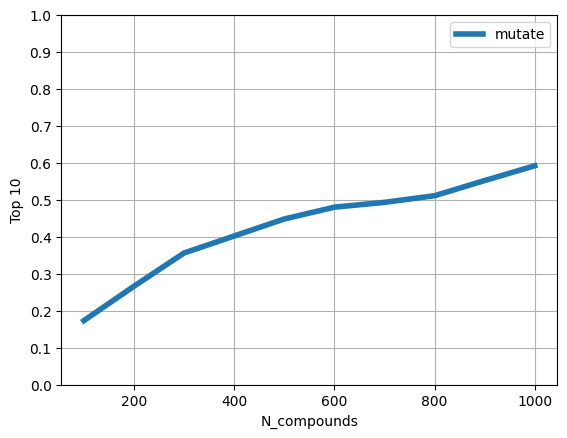

[{'top10': 0.173, 'top10_synth': 2.7540767857860793}, {'top10': 0.26600000000000007, 'top10_synth': 3.1895655668378526}, {'top10': 0.356, 'top10_synth': 3.721055169115021}, {'top10': 0.402, 'top10_synth': 3.855313370498584}, {'top10': 0.44800000000000006, 'top10_synth': 3.913476149935388}, {'top10': 0.48, 'top10_synth': 3.9275429379942617}, {'top10': 0.49300000000000005, 'top10_synth': 3.8737463596808346}, {'top10': 0.5109999999999999, 'top10_synth': 3.870297951116013}, {'top10': 0.5519999999999999, 'top10_synth': 3.878136333530093}, {'top10': 0.592, 'top10_synth': 3.8668186405536447}]


In [129]:
# 5. Plot metrics using matplotlib

import matplotlib.pyplot as plt

plt.plot([(i+1)*100 for i in range(len(mutate_metrics))],
          [m['top10'] for m in mutate_metrics], linewidth=4, label="mutate")
plt.legend()
plt.grid()
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('N_compounds')
plt.ylabel("Top 10")
plt.show()

print(mutate_metrics)

# Training loop

In [130]:
def train(train_loader: DataLoader, 
          test_loader: DataLoader,
          lr = 0.01,
          epochs = 10,
          model_type: str = 'GCN',
          concat_max_pooling: bool = False):
    
    # hyperparameters definition
    hidden_sizes = [128, 128]
    dropouts = [0.2, 0.1]
    for molecules in train_loader:
        break
    input_dim = molecules[0].x.shape[1]
    learning_rate = lr

    # model preparation
    if model_type == 'GCN':
        model = GraphNeuralNetwork(model_dim=hidden_sizes, dropout_rate=dropouts, input_dim=input_dim, \
                                   output_dim=1, concat_max_pooling=concat_max_pooling)
    elif model_type == 'GAT':
        model = GAT(in_channels=input_dim, hidden_channels=hidden_sizes[0], out_channels=1, heads=3)

    model.train()
    model = model.to(model.device)

    # training loop
    optimizer =  torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(epochs//5), gamma=0.8) if epochs > 5 \
                else torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs, gamma=0.8)

    overall_loss = epochs*[0.0]
    MAE = epochs*[0.0]
    MAE_train = epochs*[0.0]
    
    # for epoch in trange(1, epochs + 1, leave=False):
    for epoch in range(1, epochs+1):
        y_true_train = []
        # for data in tqdm(train_loader, leave=False):
        for data in train_loader:
            y = data.y
            y_true_train.append(y)
            model.zero_grad()
            preds = model(data)
            loss = loss_fn(preds, y.reshape(-1, 1))
            overall_loss[epoch-1] += loss.item() / len(data)
            loss.backward()
            optimizer.step()
        scheduler.step()
        y_true_train = np.concatenate(y_true_train)
        y_preds_train = predict(model, train_loader)
        MAE_train[epoch-1] = mean_absolute_error(y_true_train, y_preds_train)
        
        y_true = []
        y_preds = predict(model, test_loader)
        with torch.no_grad():
            for test_data in test_loader:
                y = test_data.y
                y_true.append(y)
        y_true = np.concatenate(y_true)
        MAE[epoch-1] = mean_absolute_error(y_true, y_preds)

        if epoch % 5 == 0:
            print(f"Training on epoch {epoch} ended. Train MAE = {MAE_train[epoch-1]:.4f}, test MAE = {MAE[epoch-1]:.4f}")

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot([i for i in range(1, epoch+1)], overall_loss)
    plt.xlabel("Epoch")
    plt.ylabel("Train MSE Loss")
    plt.grid(True)
    plt.tight_layout(pad=5.0)

    plt.subplot(1, 2, 2)
    plt.plot([i for i in range(1, epoch+1)], MAE)
    plt.xlabel("Epoch")
    plt.ylabel("Test MAE")
    plt.grid(True)
    plt.tight_layout(pad=5.0)
    plt.show()
    return model


def predict(model, test_loader):
    # evaluation loop
    model.eval()
    preds_batches = []
    with torch.no_grad():
        # for data in tqdm(test_loader):
        for data in test_loader:
            preds = model(data)
            preds_batches.append(preds.cpu().detach().numpy())
    preds = np.concatenate(preds_batches)
    return preds

# Split the data into training and test subsets

In [131]:
data = [cmpd for cmpd in mutate_cmpds if cmpd.activity >= 0]
data = [from_lead_compound(candidate) for candidate in data]

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

train_loader = DataLoader(
    data_train,
    batch_size=8,
    shuffle=True,
)

test_loader = DataLoader(
    data_test,
    batch_size=8,
    shuffle=False,
)

# Pre-train a GAT model on mutated compounds

Training on epoch 5 ended. Train MAE = 0.1640, test MAE = 0.0907
Training on epoch 10 ended. Train MAE = 0.1731, test MAE = 0.0911
Training on epoch 15 ended. Train MAE = 0.1792, test MAE = 0.0689
Training on epoch 20 ended. Train MAE = 0.1834, test MAE = 0.0700
Training on epoch 25 ended. Train MAE = 0.1824, test MAE = 0.0614
Training on epoch 30 ended. Train MAE = 0.1895, test MAE = 0.0837
Training on epoch 35 ended. Train MAE = 0.1814, test MAE = 0.0603
Training on epoch 40 ended. Train MAE = 0.1845, test MAE = 0.0581
Training on epoch 45 ended. Train MAE = 0.1892, test MAE = 0.0618
Training on epoch 50 ended. Train MAE = 0.1929, test MAE = 0.0550
Training on epoch 55 ended. Train MAE = 0.1781, test MAE = 0.0551
Training on epoch 60 ended. Train MAE = 0.1891, test MAE = 0.0534
Training on epoch 65 ended. Train MAE = 0.1857, test MAE = 0.0557
Training on epoch 70 ended. Train MAE = 0.1808, test MAE = 0.0582
Training on epoch 75 ended. Train MAE = 0.1920, test MAE = 0.0522
Training on

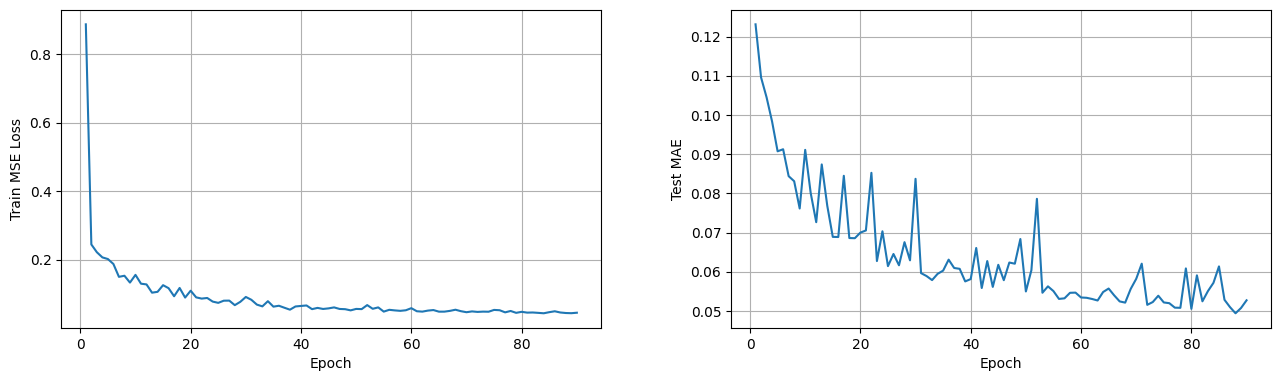

In [132]:
gat = train(train_loader, test_loader, epochs=90, lr=1e-3, model_type = 'GAT')

# Verify its quality

ρ =  0.8814731299914776
pearson =  0.9241992980642489


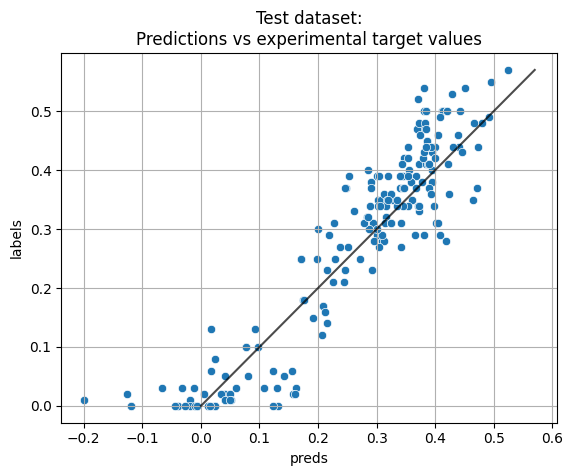

In [230]:
df_preds = pd.DataFrame({
    'preds': predict(gat, test_loader).flatten(),
    'labels': [cmpd.y for cmpd in data_test],
})

y_min = min(df_preds.labels)
y_max = max(df_preds.labels)

corr = df_preds.corr('spearman').iloc[1, 0]
pearson_corr = df_preds.corr('pearson').iloc[1, 0]
print("ρ = ", corr)
print("pearson = ", pearson_corr)
plt.plot([y_min, y_max], [y_min, y_max], c='black', alpha=0.7)
sns.scatterplot(data=df_preds, x='preds', y='labels')
plt.title("Test dataset:\nPredictions vs experimental target values")
plt.grid(True)
plt.show()

ρ =  0.9156602088600745
pearson =  0.9467319708764653


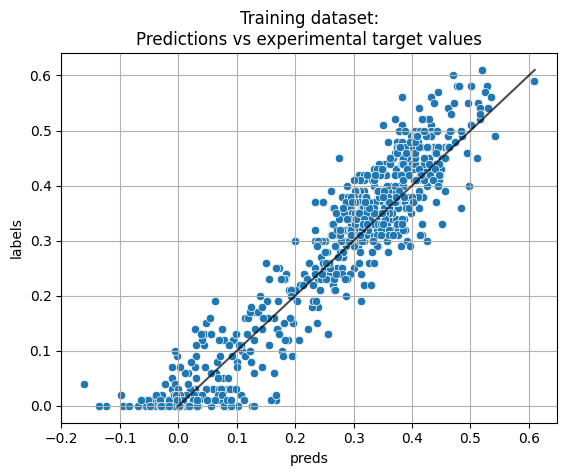

In [229]:
_train_loader = DataLoader(
    data_train,
    batch_size=8,
    shuffle=False,
)

df_preds = pd.DataFrame({
    'preds': predict(gat, _train_loader).flatten(),
    'labels': [cmpd.y for cmpd in data_train],
})

y_min = min(df_preds.labels)
y_max = max(df_preds.labels)

corr = df_preds.corr('spearman').iloc[1, 0]
pearson_corr = df_preds.corr('pearson').iloc[1, 0]
print("ρ = ", corr)
print("pearson = ", pearson_corr)
plt.plot([y_min, y_max], [y_min, y_max], c='black', alpha=0.7)
sns.scatterplot(data=df_preds, x='preds', y='labels')
plt.title("Training dataset:\nPredictions vs experimental target values")
plt.grid(True)
plt.show()

# Pre-train a GCN model on mutated compounds

Training on epoch 5 ended. Train MAE = 0.1904, test MAE = 0.0667
Training on epoch 10 ended. Train MAE = 0.2048, test MAE = 0.0560
Training on epoch 15 ended. Train MAE = 0.1898, test MAE = 0.0525
Training on epoch 20 ended. Train MAE = 0.1942, test MAE = 0.0429
Training on epoch 25 ended. Train MAE = 0.1953, test MAE = 0.0400
Training on epoch 30 ended. Train MAE = 0.1912, test MAE = 0.0373


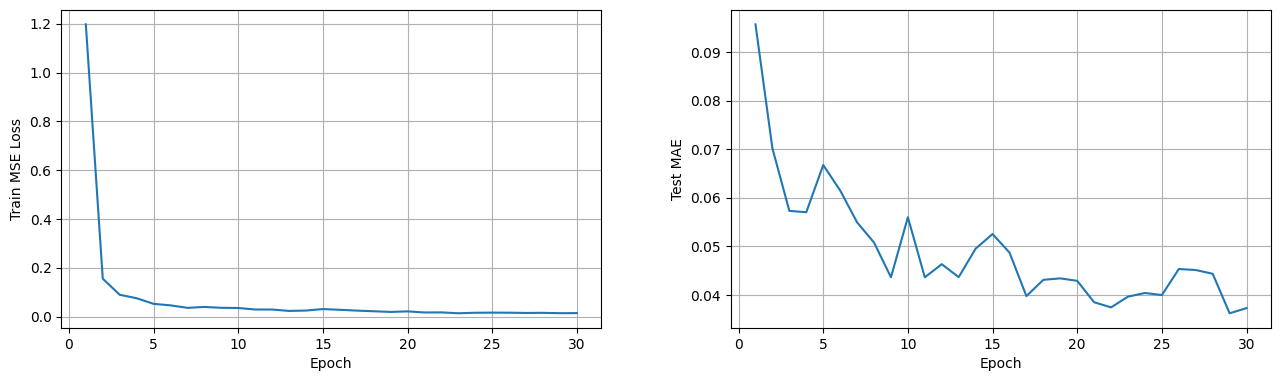

In [234]:
gcn = train(train_loader, test_loader, epochs=30, lr=5e-4, model_type = 'GCN', concat_max_pooling=True)

# Verify the quality of the learned GCN predictor

ρ =  0.9374977809674871
pearson =  0.9566434296374863


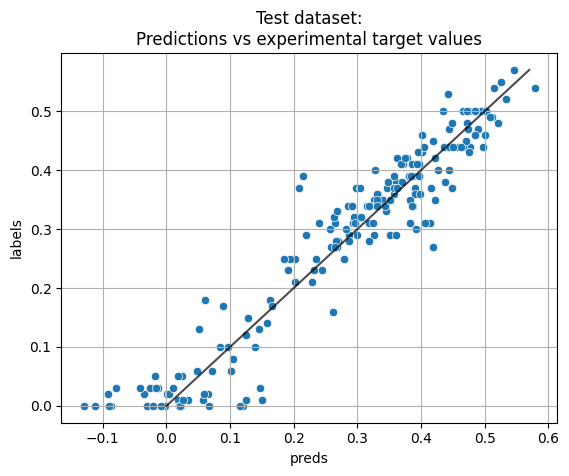

In [235]:
df_preds = pd.DataFrame({
    'preds': predict(gcn, test_loader).flatten(),
    'labels': [cmpd.y for cmpd in data_test],
})

y_min = min(df_preds.labels)
y_max = max(df_preds.labels)

corr = df_preds.corr('spearman').iloc[1, 0]
pearson_corr = df_preds.corr('pearson').iloc[1, 0]
print("ρ = ", corr)
print("pearson = ", pearson_corr)
plt.plot([y_min, y_max], [y_min, y_max], c='black', alpha=0.7)
sns.scatterplot(data=df_preds, x='preds', y='labels')
plt.title("Test dataset:\nPredictions vs experimental target values")
plt.grid(True)
plt.show()

ρ =  0.9768184901400772
pearson =  0.9860131469656079


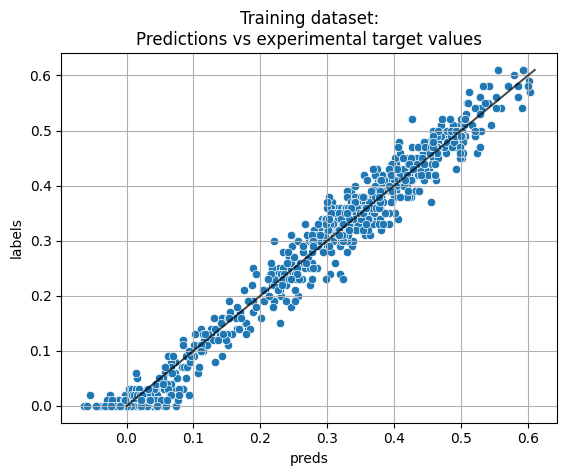

In [236]:
_train_loader = DataLoader(
    data_train,
    batch_size=8,
    shuffle=False,
)

df_preds = pd.DataFrame({
    'preds': predict(gcn, _train_loader).flatten(),
    'labels': [cmpd.y for cmpd in data_train],
})

y_min = min(df_preds.labels)
y_max = max(df_preds.labels)

corr = df_preds.corr('spearman').iloc[1, 0]
pearson_corr = df_preds.corr('pearson').iloc[1, 0]
print("ρ = ", corr)
print("pearson = ", pearson_corr)
plt.plot([y_min, y_max], [y_min, y_max], c='black', alpha=0.7)
sns.scatterplot(data=df_preds, x='preds', y='labels')
plt.title("Training dataset:\nPredictions vs experimental target values")
plt.grid(True)
plt.show()

# Save the pre-trained model weights

In [255]:
import yaml

torch.save(gcn.state_dict(), path+'/gcn_model.pt')  # 'automating-science/molecules/notebooks' + '/gcn_model.pt'
torch.save(gat.state_dict(), path+'/gat_model.pt')

#####################################################

# for molecules in train_loader:
#         break
# input_dim = molecules[0].x.shape[1]

# _params = {
#     'model_dim': [128, 128],
#     'dropout_rate': [0.2, 0.1],
#     'input_dim': input_dim,
#     'concat_max_pooling': True
#     }

# with open('gcn_params.yml', 'w') as outfile:
#     yaml.dump(_params, outfile, default_flow_style=False)

# with open('gcn_params.yml', 'r') as file:
#     params = yaml.safe_load(file)

# gcn = GraphNeuralNetwork(output_dim=1, **params)
# gcn.load_state_dict(torch.load(path+'/gcn_model.pt'), strict=False)

# Define the GNN Loop

In [252]:
class GNNLoop(Loop):
    """
    Your final implementation of the experimental loop.

    The algorithm you implement in the `propose_candidates` method will be repeated
    several times to iteratively improve your candidates.

    The molecules will be sent to the official lab endpoint with a LIMITED NUMBER OF REQUESTS,
    so use this code wisely and care for the synthesizability of your compounds!
    """
    def __init__(self, base_dir: Path, base_loop: Loop, n_warmup_iterations: int=1, user_token=None, target="DRD2", model=None):
        self.base_loop = base_loop
        self.n_warmup_iterations = n_warmup_iterations
        self._model = copy.deepcopy(model)
        super().__init__(base_dir, user_token, target)


    def _split(self, X: List[LeadCompound]) -> Tuple:
        X_temp, X_test = train_test_split(X, test_size=0.2, random_state=42)
        X_train, X_valid = train_test_split(X_temp, test_size=0.2, random_state=42)
        return X_train, X_valid, X_test


    def _get_dataloader(self, data: List[LeadCompound], batch_size:int = 16, shuffle: bool = False) -> DataLoader:
        data = [from_lead_compound(candidate) for candidate in data]
        
        loader = DataLoader(
            data,
            batch_size=batch_size,
            shuffle=shuffle
        )
        
        return loader


    def _train_model(self, candidates: List[LeadCompound], epochs: int = 10):
        candidates = [c for c in candidates if c.activity != -1.0]

        X_train, X_valid, X_test = self._split(candidates)

        console.log(f"Training set size: {len(X_train)}")
        console.log(f"Validation set size: {len(X_valid)}")
        console.log(f"Test set size: {len(X_test)}")
        console.log(f"Training set activity mean: {np.mean([c.activity for c in X_train])}")
        console.log(f"Training set activity top_10: {sorted([c.activity for c in X_train], reverse=True)[:10]}")
        console.log(f"Training set average activity top_10: {np.mean(sorted([c.activity for c in X_train], reverse=True)[:10])}")
        console.log(f"Proceeding to train GCN")

        train_loader = self._get_dataloader(X_train, batch_size=16, shuffle=True)
        
        for molecules in train_loader:
            break
        input_dim = molecules[0].x.shape[1]
        learning_rate = 1e-4
        self._model.train()
        self._model = self._model.to(self._model.device)
    
        # training loop
        optimizer =  torch.optim.Adam(self._model.parameters(), lr=learning_rate)
        loss_fn = torch.nn.MSELoss()
        for epoch in trange(1, epochs + 1, leave=False):
            for data in tqdm(train_loader, leave=False):
                y = data.y
                self._model.zero_grad()
                preds = self._model(data)
                loss = loss_fn(preds, y.reshape(-1, 1))
                loss.backward()
                optimizer.step()
        return self._model


    def _select_top_N(self, candidates: List[LeadCompound], n_select: int) -> List[LeadCompound]:
        """Ranks candidates by their predicted activity."""
        # candidates = [c for c in candidates if c.activity != -1]
        
        if len(candidates) == 0:
            raise ValueError("No previous results to train on (excluded activity = -1). Perhaps your "
                             "base loop proposes nonsynthetizable compounds?")
        console.log(f"Selecting top 10 from {len(candidates)} compounds.")
        
        test_loader = self._get_dataloader(candidates, batch_size=16, shuffle=False)
        y_pred = predict(self._model, test_loader).flatten()
        # now let's sort the compounds based on their predicted activity
        sorted_compounds = [c for _, c in sorted(zip(y_pred, candidates), reverse=True, key=lambda a: (a[0]))]

        return sorted_compounds[:n_select]
    

    def propose_candidates(self, n_candidates: int) -> List[LeadCompound]:
        if self.n_iterations < self.n_warmup_iterations:
            return self.base_loop.propose_candidates(n_candidates)

        # Load previous results
        previous_results: List[LeadCompound] = self.load()

        # Train the model
        self._train_model(previous_results, epochs=1)

        # Generate candidates
        candidates = self.base_loop.propose_candidates(n_candidates)
        # Gather all candidates
        all_candidates = previous_results + candidates

        # Remove duplicates based on SMILES strings
        smiles_seen = set()
        candidates_unique = []
        for c in all_candidates:
            if c.smiles not in smiles_seen:
                candidates_unique.append(c)
                smiles_seen.add(c.smiles)

        all_candidates = candidates_unique
        # Select the top N candidates from previous results and newly sampled compounds, based on the model's predictions
        top_candidates = self._select_top_N(all_candidates, n_candidates)
        
        return top_candidates

# Use the GNN Loop to get active compounds

Found local copy...
Loading...
Done!


[22:25:52] Saving results to mlloop1.                                                                 ]8;id=894832;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=532172;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#44\44]8;;\

           Saving results to mlloop1.                                                                 ]8;id=989369;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=785380;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#44\44]8;;\

Step 0

[22:26:01] Saving results to mlloop1\0.json.                                                         ]8;id=36681;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=839592;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_0.html for 100 compounds from iteration 0.       ]8;id=878836;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=963307;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['CCOc1ccc(CCC(=O)N2CCc3ccc(Cl)cc3C2)cc1', 'Cc1ccc(Oc2ccc(N)c(C(F)(F)F)c2)cc1C', 'O=C(Cc1ccc(CNC(=O)c2cnc3c(c2)NC(=O)CO3)cc1)Nc1ccccc1F', 'CCn1cc(C(=O)Nc2cc(C)nn2-c2ccccc2C(F)(F)F)cn1', 'Cc1ccc(C(=O)N(C)[C@@H](C)c2cccnc2)c(C)n1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'CC[C@@H](C)n1ncc2c(C(=O)N3CCC(c4noc(C)n4)CC3)cc(C)nc21', 'CC(=O)N1C=Cc2ccccc2[C@@H]1CC(=O)N1CCN(S(=O)(=O)c2ccc(C)cc2)CC1', 'Cc1cnn(C)c1C(=O)/N=c1/sc2c(C)ccc(C)c2n1C', 'O=S(=O)(c1ccc(F)cc1F)N1CCC(O)(C(F)(F)F)CC1', 'Cc1cccc(CN(C2CC2)S(=O)(=O)c2ccc3c(c2)C(=O)N(C)C3=O)c1', 'CCn1cnnc1CNC(=O)c1cccc(F)c1Cl', 'Cc1c(C#N)c2ccccc2n1CC(=O)N1CC[C@H](O)C[C@@H]1C(=O)[O-]', 'O=C(NNC(=O)c1cc(F)cc(F)c1)c1cccc(O)c1', 'O=C(NNC(=O)[C@H]1[C@@H](C(=O)[O-])[C@H]2CC[C@@H]1C2)c1cccc(Cl)c1', 'C[C@@H](NC(=O)CN(C)c1ccccc1)c1ccccc1Cl', 'CC[C@@H](O)CN(Cc1cccc(C(=O)N(C)C)c1)c1ccccc1', 'Cc1ccccc1CN1CC[NH+](CC(=O)Nc2cccc3nonc23)CC1', '[O-]C1=NC(=S)S/C1=C\\c1ccc(CSC(F)F)o1', 'O=C(c1cn(C2CCN(S(=O)(=O)c3c(F)cccc3F)CC2)nn1)N1CCCCC1', 'COCC[NH+]1CCc2nc(S

MolGridWidget()

Step 1

[22:26:10] Saving results to mlloop1\1.json.                                                         ]8;id=727307;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=41922;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_1.html for 100 compounds from iteration 1.       ]8;id=391425;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=937493;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['CCCCNC(=O)c1cccn(-c2ccc(NC(=O)c3ccc(C)cc3)cc2)c1=O', 'CC(=O)NC[C@H]1CCCN(C(=O)[C@@H]2CCO[C@H]2C)C1', 'COc1cc(OC)c(OC)cc1C[NH2+][C@H](C)c1ccc(Br)cc1', 'Cc1cccc(Cn2cccc(C(=O)NC[C@@H](O)c3ccccc3)c2=O)c1', 'CCc1ccc(C(=O)[C@H](C)Sc2nnc([C@H]3CCS(=O)(=O)C3)n2C)cc1', 'Oc1ccccc1C1OCCO1', 'CC(=O)Nc1cccc(NC(=O)[C@H](NC(=O)c2cccc(C)c2)C(C)C)c1', 'CSC1=C(C#N)[C@@H](c2ccco2)C(C(=O)Nc2ccccc2)=C(C)N1', 'CCOC(=O)C1(C(=O)C2CC2)CC2(CCCCC2)C1', 'CC(C)CCO[C@@H]1CCN(C(=O)c2cc(F)ccc2O)C1', 'CC[C@@H](C)NC(=O)c1ccc(NC(=O)N[C@@H]2CCCc3ccccc32)cc1', 'CC(=O)c1cccc(NC(=O)CCc2c(F)cccc2F)c1', 'Cc1[nH+]ccn1CCCNC(=O)c1cccc(Br)c1O', 'COC(=O)[C@@H]1CCCCC[C@H]1NC(=O)Nc1ccc(OC)c(C)c1', 'Cc1cc(C)n2nc(SCc3ccc(Br)cc3F)nc2n1', 'CC(C)c1ccc(NC(=O)CNc2cccc([N+](=O)[O-])c2)cc1', 'Fc1cccc(Cc2nc3ccccc3[nH]2)c1F', 'CC(C)C[C@H](NC(=O)OC(C)(C)C)/C(N)=N/O', 'C[C@H]1CCCC[C@@H]1CNC(=O)N1CCC(Oc2ccnc(C(N)=O)c2)CC1', 'CNC(=O)c1cc2cc(F)ccc2[nH]1', 'CCc1nc(C)sc1CN1C[C@@H]2CC[C@H](C1)[NH+](CC=C(C)C)C2', 'COc1ccc(N2CCN(C(=O)[C@H]3N=NC4=C3CSc

MolGridWidget()

Step 2

[22:26:10] Training set size: 109                                                                  ]8;id=91823;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=136863;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 28                                                                 ]8;id=971833;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=55000;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 35                                                                       ]8;id=335066;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=318350;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.03293577981651376                                         ]8;id=662783;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=757157;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.42, 0.25, 0.23, 0.22, 0.17, 0.13, 0.13, 0.1, 0.1,      ]8;id=292202;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=9491;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.09]                                                                                                   

           Training set average activity top_10: 0.184                                             ]8;id=974472;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=949729;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=815646;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=229392;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[22:26:11] Selecting top 10 from 300 compounds.                                                    ]8;id=797719;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=789237;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:26:21] Saving results to mlloop1\2.json.                                                         ]8;id=871513;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=447583;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_2.html for 100 compounds from iteration 2.       ]8;id=133164;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=341593;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COc1ccc(C(=O)c2sc3nc4c(c(-c5ccncc5)c3c2N)CCCC4)cc1OC', 'Cc1cnn(-c2cc(Br)ccn2)c1', 'CCCc1ccc([C@H]2C(C#N)=C(N)Oc3n[nH]c(C)c32)s1', 'CCC1CCC([NH3+])(c2nnc3ccncn23)CC1', 'CC[C@H](Sc1nnc2c3ccccc3n(C(C)C)c2n1)C(=O)Nc1nnc(C)s1', 'Fc1ccc2ccc(NC[C@@H]3CCCN(c4ncccn4)C3)nc2c1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'O=C(NCc1cccnc1OCC(F)(F)F)c1ccc2[nH]cnc2c1', 'CCCOc1ncnc(Nc2cc(Cl)cc(Cl)c2)c1N', 'CS[C@@H](C)C(=O)Nc1ccc(-n2ccnc2)nc1', 'CS(=O)(=O)NCCSc1nnc(C2CC2)n1C1CC1', 'O=C(NC[C@H](O)c1ccsc1)c1cc(C2CC2)nc2ccc(F)cc12', 'CCCN1CC(=O)N2[C@@H](Cc3c([nH]c4ccccc34)[C@H]2c2ccc(Cl)cc2)C1=O', 'CN1C(=O)C[C@H](C(=O)NCc2ccnc(OC(C)(C)C)c2)[C@@H]1c1cccnc1', 'CSC1=C(C#N)[C@@H](c2ccco2)C(C(=O)Nc2ccccc2)=C(C)N1', 'COc1ccc2nc(NC(=O)c3cc(Cl)c(NC(C)=O)cc3OC)sc2c1', 'Nc1ccc(-c2c(F)cc(F)cc2F)cn1', 'COCCCn1cnnc1[S@](=O)Cc1nc2ccccc2s1', 'CCCC[C@H]([NH3+])[C@H](C)c1ccncc1', 'COc1cccc([C@@H]2N=[NH+]C(=S)N2/N=C/c2cccs2)c1', 'CCOC(=O)Nc1cc(C2=N[C@H](C(=O)OC)CO2)ccn1', 'COc1ccc(N2C(=O)[C@H](N3C(=O)c4ccccc4C3=O)[C@H]2

MolGridWidget()

Step 3

[22:26:21] Training set size: 166                                                                  ]8;id=753954;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=501657;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 42                                                                 ]8;id=286009;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=526446;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 53                                                                       ]8;id=236914;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=344032;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.03355421686746988                                         ]8;id=925769;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=466368;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.25, 0.25, 0.23, 0.22, 0.21, 0.17, 0.16, 0.14, 0.13,    ]8;id=510334;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=844571;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.13]                                                                                                   

           Training set average activity top_10: 0.18899999999999997                               ]8;id=523057;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=489179;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=85387;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=365607;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[22:26:23] Selecting top 10 from 337 compounds.                                                    ]8;id=658197;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=967457;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:26:33] Saving results to mlloop1\3.json.                                                         ]8;id=861413;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=620078;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_3.html for 100 compounds from iteration 3.       ]8;id=253893;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=773927;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC=C)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[S+1]CCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2B)NCCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C=N1', 'CCCC1=CC=C([C@H1]2C(C#N)=C(N)NC3=N[NH1]C(C)=C32)S1', 'COC=C1C=C(C(=[P+1])OC=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCC=COC', 'COC1=CC=C(C(=[B-1])C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C([C+1]C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=[C+1]=C1OC', 'COC1=CC=C(C(=O)C=2[S+1]C3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2C#[O+1])NCCCC)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1]=C(O)CCO', 'COC1=CC=C(

MolGridWidget()

Step 4

[22:26:33] Training set size: 230                                                                  ]8;id=997285;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=568548;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 58                                                                 ]8;id=456640;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=957566;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 72                                                                       ]8;id=942408;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=554978;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.08421739130434781                                         ]8;id=504091;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=708973;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.46, 0.42, 0.42, 0.42, 0.42, 0.42, 0.36, 0.36, 0.34,    ]8;id=101482;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=622958;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.34]                                                                                                   

           Training set average activity top_10: 0.396                                             ]8;id=260270;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=582128;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=285281;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=109644;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[22:26:35] Selecting top 10 from 404 compounds.                                                    ]8;id=845152;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=718402;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:26:45] Saving results to mlloop1\4.json.                                                         ]8;id=260693;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=837546;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_4.html for 100 compounds from iteration 4.       ]8;id=62074;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=967433;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC=C)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[S+1]CCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2B)NCCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C=N1', 'CCCC1=CC=C([C@H1]2C(C#N)=C(N)NC3=N[NH1]C(C)=C32)S1', 'COC=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCC=COC', 'COC=C1C=C(C(=[P+1])OC=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C([C+1]C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1]=S=C(O)CCO', 'COC1=CC=C(C(=[B-1])C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=[C+1]=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(S)=C12)NCl', 'O=S(=O)(P)C1=C[NH1]C2=NC=CC(Cl)=C12', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCSC[C@@H1]=C(O)CCO', 'O=S(=O

MolGridWidget()

Step 5

[22:26:45] Training set size: 294                                                                  ]8;id=836249;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=545041;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 74                                                                 ]8;id=280040;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=74831;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 92                                                                       ]8;id=601998;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=294228;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.12112244897959183                                         ]8;id=740109;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=45731;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.46, 0.46, 0.42, 0.42, 0.42, 0.42, 0.41, 0.41, 0.4,     ]8;id=987596;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=295946;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.39]                                                                                                   

           Training set average activity top_10: 0.421                                             ]8;id=515815;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=129704;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=505903;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=768066;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

[22:26:47] Selecting top 10 from 445 compounds.                                                    ]8;id=528907;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=394207;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:26:56] Saving results to mlloop1\5.json.                                                         ]8;id=526867;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=4046;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_5.html for 100 compounds from iteration 5.       ]8;id=281223;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=614884;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC=C)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[S+1]CCCC)C=C1OC', 'O=S(=O)(C1=C2[NH1]C=NC=CC(Cl)=C12)NCCCC[C@@H1]=S=C(O)CCO', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2B)NCCCC)C=C1OC', 'CCCC1=CC=C([C@H1]2C(C#N)=C(N)NC3=N[NH1]C(C)=C32)S1', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C=N1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N=[B+1]', 'COC=C1C=C(C(=[P+1])OC=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCC=COC', 'O=S(=O)(CC1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1]=S=C(O)CCO', 'COC=C1C=C([C+1]C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1]=S=C(O)CCO', 'C1OC=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=[C+1]=C1OC', 'COC1=CC=C(C(=[B-1])C=2SC3=NC4=C(C(C5=CC=NC=C5)=C

MolGridWidget()

Step 6

[22:26:56] Training set size: 358                                                                  ]8;id=228288;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=861209;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 90                                                                 ]8;id=928985;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=503297;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 112                                                                      ]8;id=472218;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=715077;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.16921787709497207                                         ]8;id=626185;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=706497;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.48, 0.46, 0.46, 0.45, 0.45, 0.44, 0.43, 0.42, 0.42,    ]8;id=191003;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=373756;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.42]                                                                                                   

           Training set average activity top_10: 0.44299999999999995                               ]8;id=492522;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=686702;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=898645;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=210364;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

[22:26:58] Selecting top 10 from 473 compounds.                                                    ]8;id=309627;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=37175;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:27:07] Saving results to mlloop1\6.json.                                                         ]8;id=500042;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=977019;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

[22:27:08] Saving visualization to mlloop1\visualize_6.html for 100 compounds from iteration 6.       ]8;id=682566;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=617421;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC=C)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[S+1]CCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCC)C=C1OC', 'O=S(=O)(C1=C2[NH1]C=NC=CC(Cl)=C12)NCCCC[C@@H1]=S=C(O)CCO', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2B)NCCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C=N1', 'CCCC1=CC=C([C@H1]2C(C#N)=C(N)NC3=N[NH1]C(C)=C32)S1', 'O=S(=O)(C1=C[NH1]C2=NC=CC([O+1])=C12)NCCCl', 'COC=C1C=C(C(=[P+1])OC=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N=[B+1]', 'COC=C1C=C([C+1]C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCC=COC', 'O=S(=O)(CC1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1]=S=C(O)CCO', 'C1OC=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', '[O+1]=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC=[C@@H1]COCI', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=[C+1]=C1OC', 'O=S

MolGridWidget()

Step 7

[22:27:08] Training set size: 422                                                                  ]8;id=845178;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=933090;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 106                                                                ]8;id=441106;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=309259;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 132                                                                      ]8;id=889384;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=738022;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.19364928909952606                                         ]8;id=371829;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=208042;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.46, 0.46, 0.46, 0.46, 0.46, 0.45, 0.45, 0.45, 0.44,    ]8;id=236511;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=975379;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.43]                                                                                                   

           Training set average activity top_10: 0.45200000000000007                               ]8;id=530321;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=221157;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=280599;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=5491;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

[22:27:10] Selecting top 10 from 500 compounds.                                                    ]8;id=876889;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=197934;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:27:20] Saving results to mlloop1\7.json.                                                         ]8;id=890790;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=422710;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_7.html for 100 compounds from iteration 7.       ]8;id=824356;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=891786;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC=C)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[S+1]CCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCC)C=C1OC', 'O=S(=O)(C1=C2[NH1]C=NC=CC(Cl)=C12)NCCCC[C@@H1]=S=C(O)CCO', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2B)NCCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C=N1', 'CCCC1=CC=C([C@H1]2C(C#N)=C(N)NC3=N[NH1]C(C)=C32)S1', 'O=S(=O)(C1=C[NH1]C2=NC=CC([O+1])=C12)NCCCl', 'COC=C1C=C(C(=[P+1])OC=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C([C+1]C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N=[B+1]', 'COC=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCC=COC', 'O=S(=O)(CC1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1]=S=C(O)CCO', '[O+1]=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC=[C@@H1]COCI', 'C1OC=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=[C+1]=C1OC', 'COC

MolGridWidget()

Step 8

[22:27:20] Training set size: 486                                                                  ]8;id=812473;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=761592;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 122                                                                ]8;id=770322;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=324410;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 152                                                                      ]8;id=804115;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=803759;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.21370370370370373                                         ]8;id=55090;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=318902;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.53, 0.53, 0.48, 0.47, 0.47, 0.46, 0.46, 0.46, 0.46,    ]8;id=588190;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=48858;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.46]                                                                                                   

           Training set average activity top_10: 0.47800000000000004                               ]8;id=79056;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=661618;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=564438;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=941334;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[22:27:23] Selecting top 10 from 519 compounds.                                                    ]8;id=201779;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=295393;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:27:32] Saving results to mlloop1\8.json.                                                         ]8;id=656020;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=47266;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_8.html for 100 compounds from iteration 8.       ]8;id=592037;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=580830;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC=C)C=C1OC', 'O=S(=O)(C1=C2[NH1]C=NC=CC(Cl)=C12)NCCCC[C@@H1]=S=C(O)CCO', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[S+1]CCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCC)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)SCCCC=[C@@H1]COCI', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2B)NCCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C=N1', 'O=S(=O)(C1=C[NH1]C2=NC=CC([O+1])=C12)NCCCl', 'CCCC1=CC=C([C@H1]2C(C#N)=C(N)NC3=N[NH1]C(C)=C32)S1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N=[B+1]', '[O+1]=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC=[C@@H1]COCI', 'O=S(=O)(CC1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1]=S=C(O)CCO', 'COC=C1C=C(C(=[P+1])OC=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C([C+1]C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1]=S=C(O)CCO', 'COC=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCCC=COC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(C

MolGridWidget()

Step 9

[22:27:33] Training set size: 550                                                                  ]8;id=365289;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=940499;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 138                                                                ]8;id=978792;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=587624;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 172                                                                      ]8;id=964307;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=716148;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.23629090909090905                                         ]8;id=53551;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=95663;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.56, 0.54, 0.53, 0.53, 0.53, 0.52, 0.52, 0.48, 0.47,    ]8;id=653681;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=487693;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.47]                                                                                                   

           Training set average activity top_10: 0.5149999999999999                                ]8;id=863932;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=277075;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=631637;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=451944;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

[22:27:36] Selecting top 10 from 540 compounds.                                                    ]8;id=467649;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=940914;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:27:46] Saving results to mlloop1\9.json.                                                         ]8;id=795920;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=250814;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_9.html for 100 compounds from iteration 9.       ]8;id=842737;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=825441;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)SCCCC=[C@@H1][H]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)SC=[B+1]', 'O=S(=O)C1=C[NH1]C2=NC=CC(N)=C12', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)SCCCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)SCC#N', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)SCC=[B+1]', 'O=S(=O)(C1=C2[NH1]C=NC=CC(Cl)=C12)NCCCC[C@@H1]=S=C(O)CCO', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)SCCCC[H]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)SCCCC=[C@@H1]CI', 'O=C(O)PC1=C[NH1]C2=NC=CC(Cl)=C12', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC=C)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)SCCCC=[C@@H1]COC=S', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)SSCCCC=[C@@H1]COCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)SCCCC=[C@@H1]COCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)SCCCC=[C@@H1]COC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)SCCCC=[C@@H1][O-1]', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[S+1]CCCC)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)SCCCC=[C@@H1]C', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCCC)C=C1OC', 'O=S(=O)(C1=C[NH1]C2

MolGridWidget()

Found local copy...
Loading...
Done!


[22:27:47] Saving results to mlloop2.                                                                 ]8;id=352715;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=759127;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#44\44]8;;\

           Saving results to mlloop2.                                                                 ]8;id=946270;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=297997;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#44\44]8;;\

Step 0

[22:27:55] Saving results to mlloop2\0.json.                                                         ]8;id=481392;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=598143;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_0.html for 100 compounds from iteration 0.       ]8;id=840091;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=976335;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['CCOc1ccc(CCC(=O)N2CCc3ccc(Cl)cc3C2)cc1', 'Cc1ccc(Oc2ccc(N)c(C(F)(F)F)c2)cc1C', 'O=C(Cc1ccc(CNC(=O)c2cnc3c(c2)NC(=O)CO3)cc1)Nc1ccccc1F', 'CCn1cc(C(=O)Nc2cc(C)nn2-c2ccccc2C(F)(F)F)cn1', 'Cc1ccc(C(=O)N(C)[C@@H](C)c2cccnc2)c(C)n1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'CC[C@@H](C)n1ncc2c(C(=O)N3CCC(c4noc(C)n4)CC3)cc(C)nc21', 'CC(=O)N1C=Cc2ccccc2[C@@H]1CC(=O)N1CCN(S(=O)(=O)c2ccc(C)cc2)CC1', 'Cc1cnn(C)c1C(=O)/N=c1/sc2c(C)ccc(C)c2n1C', 'O=S(=O)(c1ccc(F)cc1F)N1CCC(O)(C(F)(F)F)CC1', 'Cc1cccc(CN(C2CC2)S(=O)(=O)c2ccc3c(c2)C(=O)N(C)C3=O)c1', 'CCn1cnnc1CNC(=O)c1cccc(F)c1Cl', 'Cc1c(C#N)c2ccccc2n1CC(=O)N1CC[C@H](O)C[C@@H]1C(=O)[O-]', 'O=C(NNC(=O)c1cc(F)cc(F)c1)c1cccc(O)c1', 'O=C(NNC(=O)[C@H]1[C@@H](C(=O)[O-])[C@H]2CC[C@@H]1C2)c1cccc(Cl)c1', 'C[C@@H](NC(=O)CN(C)c1ccccc1)c1ccccc1Cl', 'CC[C@@H](O)CN(Cc1cccc(C(=O)N(C)C)c1)c1ccccc1', 'Cc1ccccc1CN1CC[NH+](CC(=O)Nc2cccc3nonc23)CC1', '[O-]C1=NC(=S)S/C1=C\\c1ccc(CSC(F)F)o1', 'O=C(c1cn(C2CCN(S(=O)(=O)c3c(F)cccc3F)CC2)nn1)N1CCCCC1', 'COCC[NH+]1CCc2nc(S

MolGridWidget()

Step 1

[22:28:03] Saving results to mlloop2\1.json.                                                         ]8;id=726159;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=265553;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_1.html for 100 compounds from iteration 1.       ]8;id=146734;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=617154;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['CCCCNC(=O)c1cccn(-c2ccc(NC(=O)c3ccc(C)cc3)cc2)c1=O', 'CC(=O)NC[C@H]1CCCN(C(=O)[C@@H]2CCO[C@H]2C)C1', 'COc1cc(OC)c(OC)cc1C[NH2+][C@H](C)c1ccc(Br)cc1', 'Cc1cccc(Cn2cccc(C(=O)NC[C@@H](O)c3ccccc3)c2=O)c1', 'CCc1ccc(C(=O)[C@H](C)Sc2nnc([C@H]3CCS(=O)(=O)C3)n2C)cc1', 'Oc1ccccc1C1OCCO1', 'CC(=O)Nc1cccc(NC(=O)[C@H](NC(=O)c2cccc(C)c2)C(C)C)c1', 'CSC1=C(C#N)[C@@H](c2ccco2)C(C(=O)Nc2ccccc2)=C(C)N1', 'CCOC(=O)C1(C(=O)C2CC2)CC2(CCCCC2)C1', 'CC(C)CCO[C@@H]1CCN(C(=O)c2cc(F)ccc2O)C1', 'CC[C@@H](C)NC(=O)c1ccc(NC(=O)N[C@@H]2CCCc3ccccc32)cc1', 'CC(=O)c1cccc(NC(=O)CCc2c(F)cccc2F)c1', 'Cc1[nH+]ccn1CCCNC(=O)c1cccc(Br)c1O', 'COC(=O)[C@@H]1CCCCC[C@H]1NC(=O)Nc1ccc(OC)c(C)c1', 'Cc1cc(C)n2nc(SCc3ccc(Br)cc3F)nc2n1', 'CC(C)c1ccc(NC(=O)CNc2cccc([N+](=O)[O-])c2)cc1', 'Fc1cccc(Cc2nc3ccccc3[nH]2)c1F', 'CC(C)C[C@H](NC(=O)OC(C)(C)C)/C(N)=N/O', 'C[C@H]1CCCC[C@@H]1CNC(=O)N1CCC(Oc2ccnc(C(N)=O)c2)CC1', 'CNC(=O)c1cc2cc(F)ccc2[nH]1', 'CCc1nc(C)sc1CN1C[C@@H]2CC[C@H](C1)[NH+](CC=C(C)C)C2', 'COc1ccc(N2CCN(C(=O)[C@H]3N=NC4=C3CSc

MolGridWidget()

Step 2

[22:28:03] Training set size: 109                                                                  ]8;id=707281;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=564403;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 28                                                                 ]8;id=613268;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=605776;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 35                                                                       ]8;id=107864;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=770103;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.03293577981651376                                         ]8;id=731844;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=421;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.42, 0.25, 0.23, 0.22, 0.17, 0.13, 0.13, 0.1, 0.1,      ]8;id=76042;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=706511;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.09]                                                                                                   

           Training set average activity top_10: 0.184                                             ]8;id=474502;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=812253;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=953890;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=530399;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[22:28:04] Selecting top 10 from 300 compounds.                                                    ]8;id=68020;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=18129;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:28:13] Saving results to mlloop2\2.json.                                                         ]8;id=373429;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=999282;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_2.html for 100 compounds from iteration 2.       ]8;id=216341;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=249150;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=C(NCc1cccnc1OCC(F)(F)F)c1ccc2[nH]cnc2c1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', '[NH3+]CCOCC(=O)N1C[C@@H](C(=O)[O-])Oc2ccccc21', 'CC[C@H](C)N(Cc1ccncc1)C(=O)c1cc(S(N)(=O)=O)ccc1C', 'Nc1ccc(-c2c(F)cc(F)cc2F)cn1', 'O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'CCCc1ccc([C@H]2C(C#N)=C(N)Oc3n[nH]c(C)c32)s1', 'CC(=O)c1cccc(NC(=O)CCc2c(F)cccc2F)c1', 'CCC1CCC([NH3+])(c2nnc3ccncn23)CC1', 'COc1ccc(NC(=O)/C(C#N)=C/c2c(Oc3ccccc3F)nc3ccccn3c2=O)cc1', 'O=[N+]([O-])c1cnc(NCCc2ccc(F)cc2)c(Br)c1', 'COc1ccc2nc(NCc3ncccc3C)c(C)cc2c1', 'CSC1=C(C#N)[C@@H](c2ccco2)C(C(=O)Nc2ccccc2)=C(C)N1', 'COc1cccc([C@@H]2N=[NH+]C(=S)N2/N=C/c2cccs2)c1', 'COc1ccc(C(=O)c2sc3nc4c(c(-c5ccncc5)c3c2N)CCCC4)cc1OC', 'COc1ccc(C(=O)C2=C([O-])C(=O)N(CCc3ccccc3)[C@@H]2c2ccncc2)cc1', 'Cc1nsc(N2CCN(CCNS(C)(=O)=O)CC2)n1', 'Cc1ccc(S(=O)(=O)NCc2cccnc2OC(C)C)cc1[N+](=O)[O-]', 'CCC(=O)Nc1nc2ccc(NS(=O)(=O)c3ccc(OC)c(OC)c3)cc2s1', 'CS(=O)(=O)N1CCC(C[NH2+]Cc2nc3c(s2)CCC3)CC1', 'O=C(NC[C@H]1Cc2cccc(-c3cncnc3)c2O1)C1(c2ccc(Cl)c

MolGridWidget()

Step 3

[22:28:13] Training set size: 168                                                                  ]8;id=126369;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=411134;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 42                                                                 ]8;id=83592;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=288651;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 53                                                                       ]8;id=164574;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=90185;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.03422619047619048                                         ]8;id=905330;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=73694;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.42, 0.25, 0.23, 0.23, 0.22, 0.22, 0.21, 0.17, 0.16,    ]8;id=499710;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=52419;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.13]                                                                                                   

           Training set average activity top_10: 0.22399999999999998                               ]8;id=574901;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=419902;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=691573;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=548005;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[22:28:15] Selecting top 10 from 337 compounds.                                                    ]8;id=62650;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=295709;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:28:23] Saving results to mlloop2\3.json.                                                         ]8;id=107155;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=134813;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

[22:28:24] Saving visualization to mlloop2\visualize_3.html for 100 compounds from iteration 3.       ]8;id=36707;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=20415;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC=[C@@H1]3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3CC=3C4OCCO4', 'O=C(NCc1cccnc1OCC(F)(F)F)c1ccc2[nH]cnc2c1', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)SC=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NN3CCCC[C@@H1]3C4OCCO4', 'CC1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)[B-1]1', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2[O-1])NCCCC)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC(C3)OCCO3', 'CCCC1=CC=C([C@H1]2C(S#N)=C(N)OC3=N[NH1]C(C)=C32)S1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N(C)[C@@H1]C3OCCO3', 'COC1=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1ONC', 'CC=C1C=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)NC(N)=[NH1+1]1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC#N', 'O=SC1=C[NH1]C2=NC=CC(Cl)=C12', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'CC1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)CN=[NH1+1]1', 'CC1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)[C+1]1', 'C1CCC=CC=C([C@H1]2C(C

MolGridWidget()

Step 4

[22:28:24] Training set size: 232                                                                  ]8;id=570977;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=936135;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 58                                                                 ]8;id=265978;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=140806;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 73                                                                       ]8;id=634482;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=220827;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.08530172413793104                                         ]8;id=196238;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=143990;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.42, 0.42, 0.42, 0.41, 0.4, 0.4, 0.39, 0.39, 0.37,      ]8;id=531676;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=259714;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.36]                                                                                                   

           Training set average activity top_10: 0.398                                             ]8;id=54146;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=12838;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=738696;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=117783;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[22:28:26] Selecting top 10 from 397 compounds.                                                    ]8;id=249609;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=785991;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:28:35] Saving results to mlloop2\4.json.                                                         ]8;id=938809;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=980272;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_4.html for 100 compounds from iteration 4.       ]8;id=687207;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=85751;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC)C=C1OC', 'O=C(NCc1cccnc1OCC(F)(F)F)c1ccc2[nH]cnc2c1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC=[C@@H1]3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3CC=3C4OCCO4', 'COSC1=C[NH1]C2=NC=CC(Cl)=C12', 'O=S(=O)(C1=C[NH1]C=NC=C2C(Cl)=C12)NCC=3CC=3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1][H]', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)SC=C1OC', 'BOSC1=C[NH1]C2=NC=CC(Cl)=C12', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COC=[B+1]', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC#CCC)C=C1OC', 'CC1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)[B-1]1', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC[S+1]CC)C=C1OC', 'O=S(=N)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', '[O+1]=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3CC=3C4OCCO4', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2[O-1])NCCCC)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[P-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC#[N+1]', 'O=S(

MolGridWidget()

Step 5

[22:28:35] Training set size: 296                                                                  ]8;id=797185;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=581651;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 74                                                                 ]8;id=959019;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=553424;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 93                                                                       ]8;id=863975;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=979429;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.1322635135135135                                          ]8;id=163760;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=330162;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.5, 0.45, 0.42, 0.42, 0.41, 0.41, 0.41, 0.4, 0.4, 0.4]  ]8;id=673405;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=907979;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\

           Training set average activity top_10: 0.422                                             ]8;id=279908;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=41574;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=7960;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=836117;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

[22:28:37] Selecting top 10 from 429 compounds.                                                    ]8;id=139407;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=846130;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:28:47] Saving results to mlloop2\5.json.                                                         ]8;id=682136;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=245078;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_5.html for 100 compounds from iteration 5.       ]8;id=506045;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=61550;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC=[C@@H1]3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3CC=3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COC=[B+1]', 'O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'O=S(=N)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NN3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC4[C@@H1]3C(C)O4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3CO', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC(C3)OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1]', 'O=C(NCc1cccnc1OCC(F)(F)F)c1ccc2[nH]cnc2c1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCC=S', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[P-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)CCCC[C@@H1]SCOCC#N', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCl', '[O+1]=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3CC

MolGridWidget()

Step 6

[22:28:47] Training set size: 360                                                                  ]8;id=884129;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=74127;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 90                                                                 ]8;id=663711;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=192250;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 113                                                                      ]8;id=252650;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=122196;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.15683333333333335                                         ]8;id=259438;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=423378;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.5, 0.45, 0.44, 0.43, 0.42, 0.42, 0.42, 0.42, 0.42,     ]8;id=904233;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=147951;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.41]                                                                                                   

           Training set average activity top_10: 0.433                                             ]8;id=4189;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=638620;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=393168;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=327119;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

[22:28:50] Selecting top 10 from 442 compounds.                                                    ]8;id=764201;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=873885;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:28:59] Saving results to mlloop2\6.json.                                                         ]8;id=816669;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=265966;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_6.html for 100 compounds from iteration 6.       ]8;id=485444;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=450717;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC=[C@@H1]3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3CC=3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3C#[S-1]=3', 'O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COC=[B+1]', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC)C=C1OC', 'O=S(=N)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=C(NCc1cccnc1OCC(F)(F)F)c1ccc2[nH]cnc2c1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC=C', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[B-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[P-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NN3CCCC[C@@H1]3C4OCCO4', 'OPC1=C[NH1]C2=NC=CC(Cl)=C12', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC4[C@@H1]3C(C)O4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC(C3)OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3CO', 'O=SC1=C[NH1]C2=NC=CC(Cl)=C1

MolGridWidget()

Step 7

[22:28:59] Training set size: 424                                                                  ]8;id=159188;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=413647;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 106                                                                ]8;id=477121;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=873980;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 133                                                                      ]8;id=694793;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=185634;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.19047169811320752                                         ]8;id=317142;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=427665;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.5, 0.46, 0.45, 0.45, 0.44, 0.43, 0.43, 0.42, 0.42,     ]8;id=688532;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=778274;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.42]                                                                                                   

           Training set average activity top_10: 0.442                                             ]8;id=910212;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=540717;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=197558;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=330408;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

[22:29:02] Selecting top 10 from 477 compounds.                                                    ]8;id=982884;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=314006;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:29:11] Saving results to mlloop2\7.json.                                                         ]8;id=757154;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=184017;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

[22:29:12] Saving visualization to mlloop2\visualize_7.html for 100 compounds from iteration 7.       ]8;id=616492;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=7975;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC=[C@@H1]3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3CC=3COC[P-1]', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC)C=C1OC', 'O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3CC=3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3C#[S-1]=3', 'O=S(=N)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COC=[B+1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[P-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[B-1]', 'O=C(NCc1cccnc1OCC(F)(F)F)c1ccc2[nH]cnc2c1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)OCCCC[C@@H1]COCCOF', 'OPC1=C[NH1]C2=NC=CC(Cl)=C12', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NN3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC(C3)OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1]', 'BOSC1=C[NH1]C2=NC=CC(Cl)=C12', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC4[C@@H1]3C(C)O4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[

MolGridWidget()

Step 8

[22:29:12] Training set size: 488                                                                  ]8;id=2069;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=207124;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 122                                                                ]8;id=766865;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=884208;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 153                                                                      ]8;id=912209;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=657599;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.2033811475409836                                          ]8;id=432908;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=650782;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.5, 0.48, 0.45, 0.44, 0.43, 0.43, 0.43, 0.42, 0.42,     ]8;id=175611;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=804029;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.42]                                                                                                   

           Training set average activity top_10: 0.442                                             ]8;id=720289;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=942735;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=310038;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=264532;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[22:29:15] Selecting top 10 from 498 compounds.                                                    ]8;id=260020;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=541692;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:29:24] Saving results to mlloop2\8.json.                                                         ]8;id=424852;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=90894;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_8.html for 100 compounds from iteration 8.       ]8;id=113719;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=994001;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC=[C@@H1]3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3CC=3C4OCCO4', 'O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3CC=3CO[P-1]', 'O=S(=N)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COC=[B+1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3CC=3C[P-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)OCCCC[C@@H1]COCCO[P-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3C#[S-1]=3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3CC=3COC[P-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NN3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC4[C@@H1]3C(C)O4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)OCCCC[C@@H1]COCCO[B-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC#CCOC[P-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC(C3)OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3CO', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1

MolGridWidget()

Step 9

[22:29:25] Training set size: 552                                                                  ]8;id=347466;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=892862;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 138                                                                ]8;id=639976;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=39573;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 173                                                                      ]8;id=484854;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=150969;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.22579710144927537                                         ]8;id=443333;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=203076;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.53, 0.5, 0.5, 0.48, 0.48, 0.47, 0.46, 0.46, 0.46,      ]8;id=447710;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=163029;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.45]                                                                                                   

           Training set average activity top_10: 0.479                                             ]8;id=40108;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=238422;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=906155;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=483520;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

[22:29:28] Selecting top 10 from 525 compounds.                                                    ]8;id=537240;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=263246;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:29:37] Saving results to mlloop2\9.json.                                                         ]8;id=609871;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=455601;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_9.html for 100 compounds from iteration 9.       ]8;id=269413;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=154074;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3CC=3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC=[C@@H1]3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC#CCOC[P-1][P-1]', 'O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC)C=C1OC', 'O=S(=N)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COC=[B+1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3C#[S-1]=3', 'O=S(=O)(C1=C2[NH1]C=NC=CC(Cl)=C12)NCC=3CC=3COC[P-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC#CCOC[P-1]S', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3CC=3COC[P-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3CC=3OC[P-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NN3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=3CC=3C[P-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC4[C@@H1]3C(C)O4', 'O=SC1=C[NH1]C2=NC=CC(Cl)=C12', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)OCCCC[C@@H1]COCCO[P-1]', 'O=S(=O)

MolGridWidget()

Found local copy...
Loading...
Done!


[22:29:38] Saving results to mlloop1.                                                                 ]8;id=686284;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=12632;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#44\44]8;;\

           Saving results to mlloop1.                                                                 ]8;id=935275;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=43485;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#44\44]8;;\

Step 0

[22:29:46] Saving results to mlloop1\0.json.                                                         ]8;id=579280;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=192386;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_0.html for 100 compounds from iteration 0.       ]8;id=815776;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=962105;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['CCOc1ccc(CCC(=O)N2CCc3ccc(Cl)cc3C2)cc1', 'Cc1ccc(Oc2ccc(N)c(C(F)(F)F)c2)cc1C', 'O=C(Cc1ccc(CNC(=O)c2cnc3c(c2)NC(=O)CO3)cc1)Nc1ccccc1F', 'CCn1cc(C(=O)Nc2cc(C)nn2-c2ccccc2C(F)(F)F)cn1', 'Cc1ccc(C(=O)N(C)[C@@H](C)c2cccnc2)c(C)n1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'CC[C@@H](C)n1ncc2c(C(=O)N3CCC(c4noc(C)n4)CC3)cc(C)nc21', 'CC(=O)N1C=Cc2ccccc2[C@@H]1CC(=O)N1CCN(S(=O)(=O)c2ccc(C)cc2)CC1', 'Cc1cnn(C)c1C(=O)/N=c1/sc2c(C)ccc(C)c2n1C', 'O=S(=O)(c1ccc(F)cc1F)N1CCC(O)(C(F)(F)F)CC1', 'Cc1cccc(CN(C2CC2)S(=O)(=O)c2ccc3c(c2)C(=O)N(C)C3=O)c1', 'CCn1cnnc1CNC(=O)c1cccc(F)c1Cl', 'Cc1c(C#N)c2ccccc2n1CC(=O)N1CC[C@H](O)C[C@@H]1C(=O)[O-]', 'O=C(NNC(=O)c1cc(F)cc(F)c1)c1cccc(O)c1', 'O=C(NNC(=O)[C@H]1[C@@H](C(=O)[O-])[C@H]2CC[C@@H]1C2)c1cccc(Cl)c1', 'C[C@@H](NC(=O)CN(C)c1ccccc1)c1ccccc1Cl', 'CC[C@@H](O)CN(Cc1cccc(C(=O)N(C)C)c1)c1ccccc1', 'Cc1ccccc1CN1CC[NH+](CC(=O)Nc2cccc3nonc23)CC1', '[O-]C1=NC(=S)S/C1=C\\c1ccc(CSC(F)F)o1', 'O=C(c1cn(C2CCN(S(=O)(=O)c3c(F)cccc3F)CC2)nn1)N1CCCCC1', 'COCC[NH+]1CCc2nc(S

MolGridWidget()

Step 1

[22:29:55] Saving results to mlloop1\1.json.                                                         ]8;id=961318;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=553186;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_1.html for 100 compounds from iteration 1.       ]8;id=334412;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=567727;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['CCCCNC(=O)c1cccn(-c2ccc(NC(=O)c3ccc(C)cc3)cc2)c1=O', 'CC(=O)NC[C@H]1CCCN(C(=O)[C@@H]2CCO[C@H]2C)C1', 'COc1cc(OC)c(OC)cc1C[NH2+][C@H](C)c1ccc(Br)cc1', 'Cc1cccc(Cn2cccc(C(=O)NC[C@@H](O)c3ccccc3)c2=O)c1', 'CCc1ccc(C(=O)[C@H](C)Sc2nnc([C@H]3CCS(=O)(=O)C3)n2C)cc1', 'Oc1ccccc1C1OCCO1', 'CC(=O)Nc1cccc(NC(=O)[C@H](NC(=O)c2cccc(C)c2)C(C)C)c1', 'CSC1=C(C#N)[C@@H](c2ccco2)C(C(=O)Nc2ccccc2)=C(C)N1', 'CCOC(=O)C1(C(=O)C2CC2)CC2(CCCCC2)C1', 'CC(C)CCO[C@@H]1CCN(C(=O)c2cc(F)ccc2O)C1', 'CC[C@@H](C)NC(=O)c1ccc(NC(=O)N[C@@H]2CCCc3ccccc32)cc1', 'CC(=O)c1cccc(NC(=O)CCc2c(F)cccc2F)c1', 'Cc1[nH+]ccn1CCCNC(=O)c1cccc(Br)c1O', 'COC(=O)[C@@H]1CCCCC[C@H]1NC(=O)Nc1ccc(OC)c(C)c1', 'Cc1cc(C)n2nc(SCc3ccc(Br)cc3F)nc2n1', 'CC(C)c1ccc(NC(=O)CNc2cccc([N+](=O)[O-])c2)cc1', 'Fc1cccc(Cc2nc3ccccc3[nH]2)c1F', 'CC(C)C[C@H](NC(=O)OC(C)(C)C)/C(N)=N/O', 'C[C@H]1CCCC[C@@H]1CNC(=O)N1CCC(Oc2ccnc(C(N)=O)c2)CC1', 'CNC(=O)c1cc2cc(F)ccc2[nH]1', 'CCc1nc(C)sc1CN1C[C@@H]2CC[C@H](C1)[NH+](CC=C(C)C)C2', 'COc1ccc(N2CCN(C(=O)[C@H]3N=NC4=C3CSc

MolGridWidget()

Step 2

[22:29:55] Training set size: 109                                                                  ]8;id=841182;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=462145;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 28                                                                 ]8;id=540577;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=872613;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 35                                                                       ]8;id=519083;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=671818;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.03293577981651376                                         ]8;id=372308;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=885957;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.42, 0.25, 0.23, 0.22, 0.17, 0.13, 0.13, 0.1, 0.1,      ]8;id=424927;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=712945;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.09]                                                                                                   

           Training set average activity top_10: 0.184                                             ]8;id=968701;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=994338;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=412902;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=890029;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

           Selecting top 10 from 300 compounds.                                                    ]8;id=107282;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=792786;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:30:04] Saving results to mlloop1\2.json.                                                         ]8;id=231133;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=328069;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_2.html for 100 compounds from iteration 2.       ]8;id=842508;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=854782;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COc1ccc(C(=O)c2sc3nc4c(c(-c5ccncc5)c3c2N)CCCC4)cc1OC', 'Cc1cnn(-c2cc(Br)ccn2)c1', 'CCCc1ccc([C@H]2C(C#N)=C(N)Oc3n[nH]c(C)c32)s1', 'CCC1CCC([NH3+])(c2nnc3ccncn23)CC1', 'CC[C@H](Sc1nnc2c3ccccc3n(C(C)C)c2n1)C(=O)Nc1nnc(C)s1', 'Fc1ccc2ccc(NC[C@@H]3CCCN(c4ncccn4)C3)nc2c1', 'O=C(NCc1cccnc1OCC(F)(F)F)c1ccc2[nH]cnc2c1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'CCCOc1ncnc(Nc2cc(Cl)cc(Cl)c2)c1N', 'CS(=O)(=O)NCCSc1nnc(C2CC2)n1C1CC1', 'CS[C@@H](C)C(=O)Nc1ccc(-n2ccnc2)nc1', 'O=C(NC[C@H](O)c1ccsc1)c1cc(C2CC2)nc2ccc(F)cc12', 'CCCN1CC(=O)N2[C@@H](Cc3c([nH]c4ccccc34)[C@H]2c2ccc(Cl)cc2)C1=O', 'CN1C(=O)C[C@H](C(=O)NCc2ccnc(OC(C)(C)C)c2)[C@@H]1c1cccnc1', 'CSC1=C(C#N)[C@@H](c2ccco2)C(C(=O)Nc2ccccc2)=C(C)N1', 'COc1ccc2nc(NC(=O)c3cc(Cl)c(NC(C)=O)cc3OC)sc2c1', 'Nc1ccc(-c2c(F)cc(F)cc2F)cn1', 'COCCCn1cnnc1[S@](=O)Cc1nc2ccccc2s1', 'CCCC[C@H]([NH3+])[C@H](C)c1ccncc1', 'COc1cccc([C@@H]2N=[NH+]C(=S)N2/N=C/c2cccs2)c1', 'CCOC(=O)Nc1cc(C2=N[C@H](C(=O)OC)CO2)ccn1', 'CCc1ccc2nc(NC(=O)/C=C/C(=O)[O-])sc2c1', 'COc1cc

MolGridWidget()

Step 3

[22:30:04] Training set size: 166                                                                  ]8;id=989361;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=549017;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 42                                                                 ]8;id=549093;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=310813;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 53                                                                       ]8;id=237056;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=550243;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.03590361445783133                                         ]8;id=557082;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=977162;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.25, 0.25, 0.23, 0.22, 0.22, 0.21, 0.17, 0.16, 0.14,    ]8;id=39165;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=843683;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.13]                                                                                                   

           Training set average activity top_10: 0.198                                             ]8;id=103680;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=712360;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=932184;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=408170;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[22:30:06] Selecting top 10 from 337 compounds.                                                    ]8;id=81723;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=839941;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:30:15] Saving results to mlloop1\3.json.                                                         ]8;id=70824;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=766934;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_3.html for 100 compounds from iteration 3.       ]8;id=452515;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=117015;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COC1=CC=C([O+1](O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2[S+1])NCCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[P-1]CCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C=[C+1]1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CI)C=C1OC', 'COC=C1C=C(C(=O)[O+1]C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'CCCC1=CC=C([C@H1]2C(C#N)=C(N)NC3=N[NH1]C(C)=C32)S1', 'COC1=CC=C(C(=[P-1])C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'CCCC1=CC=C([C@H1]2C(C#N)=C([O+1])OC3=N[NH1]C(C)=C32)S1', 'COC1=CC=C(C(=[P+1])C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC1=CC=C(C(=[S+1])C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC1=CC=C(C(=O)C=2S[C+1]3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C#B', 'COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C[O-1]', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C#P=C1OC', 

MolGridWidget()

Step 4

[22:30:15] Training set size: 230                                                                  ]8;id=883173;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=300943;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 58                                                                 ]8;id=944011;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=893822;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 72                                                                       ]8;id=366725;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=973592;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.08760869565217391                                         ]8;id=1903;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=422199;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.42, 0.42, 0.42, 0.42, 0.4, 0.39, 0.37, 0.37, 0.34,     ]8;id=324044;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=809160;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.34]                                                                                                   

           Training set average activity top_10: 0.38899999999999996                               ]8;id=761723;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=960851;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=668383;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=266522;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[22:30:17] Selecting top 10 from 402 compounds.                                                    ]8;id=154308;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=146160;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:30:26] Saving results to mlloop1\4.json.                                                         ]8;id=633991;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=464624;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_4.html for 100 compounds from iteration 4.       ]8;id=289704;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=480474;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COC1=CC=C([O+1](O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=CCCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2[S+1])NCCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[P-1]CCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C=[C+1]1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CI)C=C1OC', 'COC=C1C=C(C(=O)[O+1]C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'CCCC1=CC=C([C@H1]2C(C#N)=C(N)NC3=N[NH1]C(C)=C32)S1', 'COC=C=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI)C=COC', 'COC1=CC=C(C(=[P-1])C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CI)C=C1NOC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1[C-1])NC)I', 'CCCC1=CC=C([C@H1]2C(C#N)=C([O+1])OC3=N[NH1]C(C)=C32)S1', 'COC=CC=C(CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C)I', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI)C=COC', 'COC1=CC=C(C(=[P+1])C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=

MolGridWidget()

Step 5

[22:30:26] Training set size: 294                                                                  ]8;id=68079;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=652266;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 74                                                                 ]8;id=857177;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=873388;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 92                                                                       ]8;id=802390;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=738364;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.12425170068027211                                         ]8;id=948319;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=374219;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.45, 0.42, 0.42, 0.42, 0.42, 0.41, 0.41, 0.4, 0.39,     ]8;id=881467;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=648158;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.39]                                                                                                   

           Training set average activity top_10: 0.413                                             ]8;id=971341;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=949984;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=352691;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=499497;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

[22:30:28] Selecting top 10 from 445 compounds.                                                    ]8;id=337374;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=909260;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:30:37] Saving results to mlloop1\5.json.                                                         ]8;id=644360;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=166175;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_5.html for 100 compounds from iteration 5.       ]8;id=477174;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=797914;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COC1=CC=C([O+1](O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=CCCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)OCI', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2[S+1])NCCCC)C=C1OC', 'COC=CC=C(CC=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[P-1]CCCC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C=[C+1]1OC', 'C1OC=CC=C(C(=C)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CI)C=C1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CI)C=N1', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CI)C=C1OC', 'COC=C1C=C(C(=O)[O+1]C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'CCCC1=CC=C([C@H1]2C(C#N)=C(N)NC3=N[NH1]C(C)=C32)S1', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CI)C=C1OCl', 'O=S(=O)(C1=C[NH1]C2=NC=CC(B)=C12)F', 'C1OC=CC=C1C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CI', 'C1OC=CC=C(C(=O)C=2SC3=NN=C(C(C4=CC=NC=C4)=C3C=2N)CI)C=C1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=

MolGridWidget()

Step 6

[22:30:38] Training set size: 358                                                                  ]8;id=489243;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=717471;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 90                                                                 ]8;id=857262;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=402566;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 112                                                                      ]8;id=638554;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=350207;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.1698882681564246                                          ]8;id=176874;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=760894;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.49, 0.46, 0.45, 0.45, 0.43, 0.43, 0.43, 0.42, 0.42,    ]8;id=608507;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=213956;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.42]                                                                                                   

           Training set average activity top_10: 0.44000000000000006                               ]8;id=289446;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=714769;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=158943;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=863598;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

[22:30:40] Selecting top 10 from 483 compounds.                                                    ]8;id=990633;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=861986;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:30:49] Saving results to mlloop1\6.json.                                                         ]8;id=646225;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=770154;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_6.html for 100 compounds from iteration 6.       ]8;id=812127;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=484081;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C=C1[NH1]C2=NC=CC(N)=C12)OCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O', 'COC1=CC=C([O+1](O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'O=S(=O)(P)C1=C[NH1]C2=NC=CC(N)=C12', 'COC=CCCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)OCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)OBr', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2[S+1])NCCCC)C=C1OC', 'O=S(=[O+1])(C1=C[NH1]C2=NC=CC(Cl)=C12)OCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)[O+1]F', 'COC=CC=C(CC=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C=[C+1]1OC', 'O=S(=O)(C=C[NH1]C1=NC=CC(N2)=C21)OCI', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)[P-1]CCCC)C=C1OC', 'C1OC=CC=C(C(=C)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CI)C=C1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CI)C=N1', 'OC=CC=C(CC=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI', 'O1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CI)C=N1', 'COC=CC=CCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI', 

MolGridWidget()

Step 7

[22:30:50] Training set size: 422                                                                  ]8;id=269737;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=729879;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 106                                                                ]8;id=602589;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=397476;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 132                                                                      ]8;id=708092;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=21311;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.19831753554502368                                         ]8;id=716958;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=687388;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.49, 0.49, 0.48, 0.46, 0.46, 0.46, 0.46, 0.45, 0.45,    ]8;id=106403;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=201753;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.44]                                                                                                   

           Training set average activity top_10: 0.4640000000000001                                ]8;id=490830;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=189282;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=438941;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=675168;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

[22:30:53] Selecting top 10 from 526 compounds.                                                    ]8;id=923569;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=835756;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:31:02] Saving results to mlloop1\7.json.                                                         ]8;id=724927;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=883879;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_7.html for 100 compounds from iteration 7.       ]8;id=826352;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=600526;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[O+1]I', 'O=S(=O)(C=C1[NH1]C2=NC=CC(N)=C12)OCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[P+1]Br', 'O=S(=O)(C1=C)[NH1]C2=NC=CC(N)=C12', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI)C=N[C+1]', 'O=S(=O)(P)C1=C[NH1]C2=NC=CC(N)=C12', 'COC1=CC=C([O+1](O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'C1=NC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CI)C=N1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[C+1]I', 'O=S(=O)C1=C[NH1]C2=NC=CC(N)=C12', 'COC=CCCC(=C)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)OC', 'COC=CCCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)OCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)OF', 'C1OCC=C(C(=C)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CI)C=C1OC', 'COC=CC#CC(=C)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[B+1]Br', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)OCCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)OBr', 'O=S(=[O+1])(C1=C[NH1]C2

MolGridWidget()

Step 8

[22:31:02] Training set size: 486                                                                  ]8;id=705212;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=854696;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 122                                                                ]8;id=58830;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=174183;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 152                                                                      ]8;id=980320;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=319164;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.21812757201646088                                         ]8;id=852396;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=918400;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.51, 0.49, 0.49, 0.49, 0.49, 0.48, 0.46, 0.46, 0.46,    ]8;id=258576;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=695834;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.46]                                                                                                   

           Training set average activity top_10: 0.479                                             ]8;id=186027;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=544487;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=128538;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=494972;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[22:31:06] Selecting top 10 from 567 compounds.                                                    ]8;id=763041;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=809116;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:31:16] Saving results to mlloop1\8.json.                                                         ]8;id=695462;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=93186;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_8.html for 100 compounds from iteration 8.       ]8;id=919215;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=604525;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C1=N[NH1]C2=NC=CC(N)=C12)O[O+1]I', 'O=S(=[O+1])(C1=C[NH1]C2=NC=CC(N)=C12)OF', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)[O+1]I', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)S[O+1]I', 'O=C(O)PC1=C[NH1]C2=NC=CC(N)=C12', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[O+1]I', 'O=S(=O)(C=C1[NH1]C2=NC=CC(N)=C12)OCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)OC[P+1]Br', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[P+1]Br', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[C+1]Br', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[O+1]=[O+1]', 'O=S(=O)(C1=C)[NH1]C2=NC=CC(N)=C12', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI)C=N[C+1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[S+1]I', 'O=S(=O)(P)C1=C[NH1]C2=NC=CC(N)=C12', 'COC1=CC=C([O+1](O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'C1=NC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CI)C=N1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[P+1]C', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)OCP', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[C+1]I', 'O=S(=O)=[N+1]C1=C[NH1]C2=NC=CC(N)=C12', 'O

MolGridWidget()

Step 9

[22:31:17] Training set size: 550                                                                  ]8;id=23469;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=299617;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 138                                                                ]8;id=426241;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=281345;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 172                                                                      ]8;id=338537;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=239272;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.23956363636363634                                         ]8;id=585480;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=942241;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.52, 0.51, 0.51, 0.5, 0.49, 0.49, 0.49, 0.49, 0.49,     ]8;id=552281;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=942505;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.49]                                                                                                   

           Training set average activity top_10: 0.49800000000000005                               ]8;id=528735;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=375133;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=993870;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=810754;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

[22:31:22] Selecting top 10 from 611 compounds.                                                    ]8;id=622313;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=26521;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:31:31] Saving results to mlloop1\9.json.                                                         ]8;id=543781;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=32344;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_9.html for 100 compounds from iteration 9.       ]8;id=264374;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=851137;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C1=N[NH1]C2=NC=CC(N)=C12)O[O+1]I', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)[O+1]Br', 'O=S(=[O+1])(C1=C[NH1]C2=NC=CC(N)=C12)OF', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)[O+1]I', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)S[O+1]I', 'O=C(O)PC1=C[NH1]C2=NC=CC(N)=C12', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)C[P+1]Br', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[O+1]I', 'O=S(=O)(C=C1[NH1]C2=NC=CC(N)=C12)OCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)S[P+1]Br', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[H]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)[B+1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)OC[P+1]Br', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[P+1]Br', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)[P+1]Br', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[B+1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[O+1]=[O+1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[C+1]Br', 'O=S(=O)(C1=C)[NH1]C2=NC=CC(N)=C12', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)O[S+1]I', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI)C=N[C+1]', 'O=S(=O)(P)C1=C[NH1]C2=NC=CC(N)=C12

MolGridWidget()

Found local copy...
Loading...
Done!


[22:31:32] Saving results to mlloop2.                                                                 ]8;id=491100;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=333331;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#44\44]8;;\

           Saving results to mlloop2.                                                                 ]8;id=602231;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=246173;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#44\44]8;;\

Step 0

[22:31:40] Saving results to mlloop2\0.json.                                                         ]8;id=474342;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=924149;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_0.html for 100 compounds from iteration 0.       ]8;id=183049;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=444330;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['CCOc1ccc(CCC(=O)N2CCc3ccc(Cl)cc3C2)cc1', 'Cc1ccc(Oc2ccc(N)c(C(F)(F)F)c2)cc1C', 'O=C(Cc1ccc(CNC(=O)c2cnc3c(c2)NC(=O)CO3)cc1)Nc1ccccc1F', 'CCn1cc(C(=O)Nc2cc(C)nn2-c2ccccc2C(F)(F)F)cn1', 'Cc1ccc(C(=O)N(C)[C@@H](C)c2cccnc2)c(C)n1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'CC[C@@H](C)n1ncc2c(C(=O)N3CCC(c4noc(C)n4)CC3)cc(C)nc21', 'CC(=O)N1C=Cc2ccccc2[C@@H]1CC(=O)N1CCN(S(=O)(=O)c2ccc(C)cc2)CC1', 'Cc1cnn(C)c1C(=O)/N=c1/sc2c(C)ccc(C)c2n1C', 'O=S(=O)(c1ccc(F)cc1F)N1CCC(O)(C(F)(F)F)CC1', 'Cc1cccc(CN(C2CC2)S(=O)(=O)c2ccc3c(c2)C(=O)N(C)C3=O)c1', 'CCn1cnnc1CNC(=O)c1cccc(F)c1Cl', 'Cc1c(C#N)c2ccccc2n1CC(=O)N1CC[C@H](O)C[C@@H]1C(=O)[O-]', 'O=C(NNC(=O)c1cc(F)cc(F)c1)c1cccc(O)c1', 'O=C(NNC(=O)[C@H]1[C@@H](C(=O)[O-])[C@H]2CC[C@@H]1C2)c1cccc(Cl)c1', 'C[C@@H](NC(=O)CN(C)c1ccccc1)c1ccccc1Cl', 'CC[C@@H](O)CN(Cc1cccc(C(=O)N(C)C)c1)c1ccccc1', 'Cc1ccccc1CN1CC[NH+](CC(=O)Nc2cccc3nonc23)CC1', '[O-]C1=NC(=S)S/C1=C\\c1ccc(CSC(F)F)o1', 'O=C(c1cn(C2CCN(S(=O)(=O)c3c(F)cccc3F)CC2)nn1)N1CCCCC1', 'COCC[NH+]1CCc2nc(S

MolGridWidget()

Step 1

[22:31:49] Saving results to mlloop2\1.json.                                                         ]8;id=325501;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=452632;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_1.html for 100 compounds from iteration 1.       ]8;id=537327;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=573891;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['CCCCNC(=O)c1cccn(-c2ccc(NC(=O)c3ccc(C)cc3)cc2)c1=O', 'CC(=O)NC[C@H]1CCCN(C(=O)[C@@H]2CCO[C@H]2C)C1', 'COc1cc(OC)c(OC)cc1C[NH2+][C@H](C)c1ccc(Br)cc1', 'Cc1cccc(Cn2cccc(C(=O)NC[C@@H](O)c3ccccc3)c2=O)c1', 'CCc1ccc(C(=O)[C@H](C)Sc2nnc([C@H]3CCS(=O)(=O)C3)n2C)cc1', 'Oc1ccccc1C1OCCO1', 'CC(=O)Nc1cccc(NC(=O)[C@H](NC(=O)c2cccc(C)c2)C(C)C)c1', 'CSC1=C(C#N)[C@@H](c2ccco2)C(C(=O)Nc2ccccc2)=C(C)N1', 'CCOC(=O)C1(C(=O)C2CC2)CC2(CCCCC2)C1', 'CC(C)CCO[C@@H]1CCN(C(=O)c2cc(F)ccc2O)C1', 'CC[C@@H](C)NC(=O)c1ccc(NC(=O)N[C@@H]2CCCc3ccccc32)cc1', 'CC(=O)c1cccc(NC(=O)CCc2c(F)cccc2F)c1', 'Cc1[nH+]ccn1CCCNC(=O)c1cccc(Br)c1O', 'COC(=O)[C@@H]1CCCCC[C@H]1NC(=O)Nc1ccc(OC)c(C)c1', 'Cc1cc(C)n2nc(SCc3ccc(Br)cc3F)nc2n1', 'CC(C)c1ccc(NC(=O)CNc2cccc([N+](=O)[O-])c2)cc1', 'Fc1cccc(Cc2nc3ccccc3[nH]2)c1F', 'CC(C)C[C@H](NC(=O)OC(C)(C)C)/C(N)=N/O', 'C[C@H]1CCCC[C@@H]1CNC(=O)N1CCC(Oc2ccnc(C(N)=O)c2)CC1', 'CNC(=O)c1cc2cc(F)ccc2[nH]1', 'CCc1nc(C)sc1CN1C[C@@H]2CC[C@H](C1)[NH+](CC=C(C)C)C2', 'COc1ccc(N2CCN(C(=O)[C@H]3N=NC4=C3CSc

MolGridWidget()

Step 2

[22:31:49] Training set size: 109                                                                  ]8;id=41412;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=705870;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 28                                                                 ]8;id=207461;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=279442;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 35                                                                       ]8;id=670178;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=454009;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.03293577981651376                                         ]8;id=830094;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=538796;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.42, 0.25, 0.23, 0.22, 0.17, 0.13, 0.13, 0.1, 0.1,      ]8;id=358086;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=31778;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.09]                                                                                                   

           Training set average activity top_10: 0.184                                             ]8;id=152958;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=881950;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=893279;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=404352;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

           Selecting top 10 from 300 compounds.                                                    ]8;id=548882;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=6933;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:32:04] Saving results to mlloop2\2.json.                                                         ]8;id=509126;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=312919;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_2.html for 100 compounds from iteration 2.       ]8;id=79900;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=889975;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['[NH3+]CCOCC(=O)N1C[C@@H](C(=O)[O-])Oc2ccccc21', 'O=C(NCc1cccnc1OCC(F)(F)F)c1ccc2[nH]cnc2c1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'CC[C@H](C)N(Cc1ccncc1)C(=O)c1cc(S(N)(=O)=O)ccc1C', 'CCCc1ccc([C@H]2C(C#N)=C(N)Oc3n[nH]c(C)c32)s1', 'Nc1ccc(-c2c(F)cc(F)cc2F)cn1', 'CCC1CCC([NH3+])(c2nnc3ccncn23)CC1', 'CC(=O)c1cccc(NC(=O)CCc2c(F)cccc2F)c1', 'COc1ccc(C(=O)c2sc3nc4c(c(-c5ccncc5)c3c2N)CCCC4)cc1OC', 'COc1ccc(C(=O)C2=C([O-])C(=O)N(CCc3ccccc3)[C@@H]2c2ccncc2)cc1', 'COc1ccc2nc(NCc3ncccc3C)c(C)cc2c1', 'COc1ccc(NC(=O)/C(C#N)=C/c2c(Oc3ccccc3F)nc3ccccn3c2=O)cc1', 'O=[N+]([O-])c1cnc(NCCc2ccc(F)cc2)c(Br)c1', 'CSC1=C(C#N)[C@@H](c2ccco2)C(C(=O)Nc2ccccc2)=C(C)N1', 'CC[C@H](CO)NC(=O)C(=O)Nc1cccc(C#Cc2ccccc2)c1', 'O=C(NC[C@H]1Cc2cccc(-c3cncnc3)c2O1)C1(c2ccc(Cl)cc2)CC1', 'Cc1ccc(S(=O)(=O)NCc2cccnc2OC(C)C)cc1[N+](=O)[O-]', 'CN[C@@H]1C(=O)Nc2cc(S[C@@H]3CCC[C@@H](C)C3)c(Cl)cc21', 'COc1cccc([C@@H]2N=[NH+]C(=S)N2/N=C/c2cccs2)c1', 'CCCOCC(=O)N(C)c1cc(-c2

MolGridWidget()

Step 3

[22:32:04] Training set size: 168                                                                  ]8;id=671495;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=576664;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 43                                                                 ]8;id=702991;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=705664;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 53                                                                       ]8;id=441796;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=936099;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.036488095238095236                                        ]8;id=718645;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=423922;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.42, 0.42, 0.25, 0.23, 0.22, 0.17, 0.16, 0.16, 0.13,    ]8;id=828769;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=876496;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.13]                                                                                                   

           Training set average activity top_10: 0.22899999999999995                               ]8;id=47811;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=534601;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=24975;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=901040;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[22:32:07] Selecting top 10 from 338 compounds.                                                    ]8;id=130358;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=357791;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:32:24] Saving results to mlloop2\3.json.                                                         ]8;id=693106;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=199477;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_3.html for 100 compounds from iteration 3.       ]8;id=556151;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=500709;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['C[P-1]C1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'COC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC[O-1])SC=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2B)NCCCC)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC[C@@H1]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C=COC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC[H]', 'C1OC=CC=C(C(=O)CSC2=NC=C(C(C3=CC=NC=C3)=C2)CCCC)C=C1OC', 'COC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)C=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C=COC', 'COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C=CC', 'COC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCI)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC=[C@@H1]C3OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3NC4OCCO4', 'C[B+1]CC=C(C1=CC=C(C2=CC=N[NH1]2)C=C1)C(N)=[NH1+1]', 'COC=[S-1]1=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1]C3OCCO3', 'BOC1=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC

MolGridWidget()

Step 4

[22:32:25] Training set size: 232                                                                  ]8;id=839191;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=675694;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 59                                                                 ]8;id=332009;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=611034;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 73                                                                       ]8;id=612467;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=808862;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.09021551724137931                                         ]8;id=188659;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=27630;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.44, 0.42, 0.42, 0.42, 0.42, 0.42, 0.42, 0.41, 0.41,    ]8;id=8853;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=410075;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.39]                                                                                                   

           Training set average activity top_10: 0.417                                             ]8;id=38716;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=278274;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=624659;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=247724;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[22:32:30] Selecting top 10 from 398 compounds.                                                    ]8;id=662625;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=645528;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:32:42] Saving results to mlloop2\4.json.                                                         ]8;id=939595;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=925398;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_4.html for 100 compounds from iteration 4.       ]8;id=577223;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=602743;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC[O-1])SC=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC[C@@H1]', 'C[P-1]C1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCOC', 'O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCC=O', 'O=S(=O)(C1=C[NH1]C=NC=CC(Cl)=C1)CCC[C@@H1]C2OCCO2', 'O=C(NCc1cccnc1OCC(F)(F)F)c1ccc2[nH]cnc2c1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1]COCC#SO', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC#CC3OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1]C3=[C-1]CCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NC3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)CCCC[C@@H1]NC3OCCO3', 'COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C=CC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C=COC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC

MolGridWidget()

Step 5

[22:32:43] Training set size: 296                                                                  ]8;id=872074;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=544543;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 75                                                                 ]8;id=483522;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=436846;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 93                                                                       ]8;id=410692;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=274259;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.12182432432432433                                         ]8;id=873095;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=912278;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.47, 0.44, 0.44, 0.44, 0.44, 0.42, 0.42, 0.42, 0.42,    ]8;id=980837;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=579189;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.42]                                                                                                   

           Training set average activity top_10: 0.433                                             ]8;id=601241;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=696341;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=744392;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=358459;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

[22:32:46] Selecting top 10 from 438 compounds.                                                    ]8;id=24386;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=782218;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:32:58] Saving results to mlloop2\5.json.                                                         ]8;id=655792;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=880471;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_5.html for 100 compounds from iteration 5.       ]8;id=5492;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=449233;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'O=S(=O)(CC1=C[NH1]C2=NC=CC(Cl)=C12)CCCC[C@@H1]C3OCCO3', 'O=S(=O)(C1=C[NH1]C=NC=CC(Cl)=C1)CCCC[C@@H1]C2OCCO2', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NOCCCC[C@@H1]', 'O=S(=O)(C1=C[NH1]C=NC=CC(Cl)=C1)CCC[C@@H1]C2OCCO2', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)CCCC[C@@H1]NC3OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC[C@@H1]', 'O=S(=[O+1])(C1=C[NH1]C2=NC=CC(Cl)=C12)CCCC[C@@H1]C3OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCC=O', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NC3CCCC[C@@H1]3C4OCCO4', 'C[P-1]C1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCOC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)CCCC[C@@H1]=CC3OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC#CC3OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC[C@@H1]C3OCCO3', 'COC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC[O-1])SC=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)CCCC[C@@H1]C3OCCO3', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C

MolGridWidget()

Step 6

[22:32:58] Training set size: 360                                                                  ]8;id=18872;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=29698;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 91                                                                 ]8;id=980863;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=786242;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 113                                                                      ]8;id=382748;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=227232;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.17341666666666666                                         ]8;id=997814;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=407899;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.46, 0.45, 0.45, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44,    ]8;id=152342;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=562125;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.43]                                                                                                   

           Training set average activity top_10: 0.44299999999999995                               ]8;id=644254;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=301442;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=61674;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=669453;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

[22:33:02] Selecting top 10 from 486 compounds.                                                    ]8;id=86863;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=482093;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:33:16] Saving results to mlloop2\6.json.                                                         ]8;id=753105;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=102028;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_6.html for 100 compounds from iteration 6.       ]8;id=240750;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=642900;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC#C[C@@H1]N3COCC3', 'O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC3COCC3', 'BOC=CC=C(C=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC[C@@H1]N3COCC3', 'C(=C)C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)=[B+1]', 'COC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC[O-1])SC=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC=NC=[C@@H1]C3OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)CC=NC[C@@H1]C3OCCO3', 'BOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)CNO', 'C[P-1]C1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C=COS', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C=CO', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)CCCC[C@@H1]NC3OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC#CC3OCCO3', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C=[N-1])C=COC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C=[N-1]', 'BOC=CC=C(C(=

MolGridWidget()

Step 7

[22:33:16] Training set size: 424                                                                  ]8;id=443284;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=355133;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 107                                                                ]8;id=607599;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=224069;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 133                                                                      ]8;id=748705;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=299113;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.20547169811320756                                         ]8;id=400003;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=366459;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.48, 0.47, 0.47, 0.47, 0.46, 0.46, 0.46, 0.46, 0.46,    ]8;id=833731;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=551359;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.46]                                                                                                   

           Training set average activity top_10: 0.465                                             ]8;id=437377;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=148875;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=244275;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=183987;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

[22:33:20] Selecting top 10 from 523 compounds.                                                    ]8;id=265727;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=478780;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:33:33] Saving results to mlloop2\7.json.                                                         ]8;id=722216;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=455984;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_7.html for 100 compounds from iteration 7.       ]8;id=284714;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=79958;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['C=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C=COO', 'OC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C#B', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)C=NC[C@@H1]C3OCCO3', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C=C=NO', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCS)C[O+1]=[N-1]', 'COC=CC=C(C(=[B+1])OC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC)I', 'C(=C)C(C=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)CC=N[C@@H1]C3OCCO3', 'COC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC[O-1])SC=C1OC', 'O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C=CO', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)COO', 'O=S(=O)(CC1=C[NH1]C2=NC=CC(Cl)=C12)CC=NC[C@@H1]C3OCCO3', 'BOC=CC=C(C=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1NCCI', 'BOC=CC=C(C=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)NCCI', 'BOCC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C=COC', 'BOC=CC=C(C=O)NC=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI', 'COC=

MolGridWidget()

Step 8

[22:33:34] Training set size: 488                                                                  ]8;id=50955;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=619594;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 123                                                                ]8;id=743814;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=430189;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 153                                                                      ]8;id=939836;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=210504;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.2251844262295082                                          ]8;id=787909;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=454628;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.48, 0.48, 0.48, 0.47, 0.47, 0.47, 0.47, 0.47, 0.47,    ]8;id=740046;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=427260;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.47]                                                                                                   

           Training set average activity top_10: 0.473                                             ]8;id=947240;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=11540;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=159864;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=66041;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[22:33:39] Selecting top 10 from 559 compounds.                                                    ]8;id=213951;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=179504;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:33:53] Saving results to mlloop2\8.json.                                                         ]8;id=694598;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=137085;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_8.html for 100 compounds from iteration 8.       ]8;id=769852;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=688790;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)CCC[C@@H1]C3OCCO3', 'OC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C#B', 'BOC=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)C=NC[C@@H1]C3OCCO3', 'O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'BOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)CBr', '[B-1]OC=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI', 'C=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C=COO', 'C=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C#B', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C=C=NO', 'COC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC[O-1])SC=C1OC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)CCC=NC[C@@H1]C3OCCO3', 'COCCC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C#B', 'NCOOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)[O-1]', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C=CO', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)CCCC[C@@H1]NC3OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC=[C@@H1]N3COCC3', 'BOC=CC

MolGridWidget()

Step 9

[22:33:53] Training set size: 552                                                                  ]8;id=427515;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=525390;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 139                                                                ]8;id=915868;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=670770;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 173                                                                      ]8;id=876817;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=863242;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.2495289855072464                                          ]8;id=143137;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=784195;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.52, 0.52, 0.48, 0.48, 0.48, 0.48, 0.48, 0.47, 0.47,    ]8;id=523062;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=279053;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.47]                                                                                                   

           Training set average activity top_10: 0.485                                             ]8;id=430610;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=421544;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=446626;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=943162;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

[22:33:59] Selecting top 10 from 589 compounds.                                                    ]8;id=472556;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=115744;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:34:13] Saving results to mlloop2\9.json.                                                         ]8;id=627753;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=82909;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_9.html for 100 compounds from iteration 9.       ]8;id=314378;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=856931;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['OC=CC=C(C(=O)C=1NC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)CB', 'OC=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI', 'OC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C#B', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)CCC[C@@H1]C3OCCO3', 'O=S=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C#B', 'O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)C=NC[C@@H1]C3OCCO3', 'OC=CC=C(C=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI', 'BOC=CC=CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI', 'C=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C#B', 'COC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC[O-1])SC=C1OC', 'OC=CC=CC(=O)C=1SC2=NC=CC(C3=CC=NC=C3)=C2C=1NCCI', 'BOC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)CBr', 'OC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CI)C#B', 'C=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C=COO', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)C=C=NO', 'OC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CCI)B', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C

MolGridWidget()

Found local copy...
Loading...
Done!


[22:34:14] Saving results to mlloop1.                                                                 ]8;id=950200;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=330793;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#44\44]8;;\

           Saving results to mlloop1.                                                                 ]8;id=4105;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=547024;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#44\44]8;;\

Step 0

[22:34:24] Saving results to mlloop1\0.json.                                                         ]8;id=993986;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=731651;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_0.html for 100 compounds from iteration 0.       ]8;id=939274;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=303430;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['CCOc1ccc(CCC(=O)N2CCc3ccc(Cl)cc3C2)cc1', 'Cc1ccc(Oc2ccc(N)c(C(F)(F)F)c2)cc1C', 'O=C(Cc1ccc(CNC(=O)c2cnc3c(c2)NC(=O)CO3)cc1)Nc1ccccc1F', 'CCn1cc(C(=O)Nc2cc(C)nn2-c2ccccc2C(F)(F)F)cn1', 'Cc1ccc(C(=O)N(C)[C@@H](C)c2cccnc2)c(C)n1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'CC[C@@H](C)n1ncc2c(C(=O)N3CCC(c4noc(C)n4)CC3)cc(C)nc21', 'CC(=O)N1C=Cc2ccccc2[C@@H]1CC(=O)N1CCN(S(=O)(=O)c2ccc(C)cc2)CC1', 'Cc1cnn(C)c1C(=O)/N=c1/sc2c(C)ccc(C)c2n1C', 'O=S(=O)(c1ccc(F)cc1F)N1CCC(O)(C(F)(F)F)CC1', 'Cc1cccc(CN(C2CC2)S(=O)(=O)c2ccc3c(c2)C(=O)N(C)C3=O)c1', 'CCn1cnnc1CNC(=O)c1cccc(F)c1Cl', 'Cc1c(C#N)c2ccccc2n1CC(=O)N1CC[C@H](O)C[C@@H]1C(=O)[O-]', 'O=C(NNC(=O)c1cc(F)cc(F)c1)c1cccc(O)c1', 'O=C(NNC(=O)[C@H]1[C@@H](C(=O)[O-])[C@H]2CC[C@@H]1C2)c1cccc(Cl)c1', 'C[C@@H](NC(=O)CN(C)c1ccccc1)c1ccccc1Cl', 'CC[C@@H](O)CN(Cc1cccc(C(=O)N(C)C)c1)c1ccccc1', 'Cc1ccccc1CN1CC[NH+](CC(=O)Nc2cccc3nonc23)CC1', '[O-]C1=NC(=S)S/C1=C\\c1ccc(CSC(F)F)o1', 'O=C(c1cn(C2CCN(S(=O)(=O)c3c(F)cccc3F)CC2)nn1)N1CCCCC1', 'COCC[NH+]1CCc2nc(S

MolGridWidget()

Step 1

[22:34:36] Saving results to mlloop1\1.json.                                                         ]8;id=135751;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=876991;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_1.html for 100 compounds from iteration 1.       ]8;id=541161;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=605517;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['CCCCNC(=O)c1cccn(-c2ccc(NC(=O)c3ccc(C)cc3)cc2)c1=O', 'CC(=O)NC[C@H]1CCCN(C(=O)[C@@H]2CCO[C@H]2C)C1', 'COc1cc(OC)c(OC)cc1C[NH2+][C@H](C)c1ccc(Br)cc1', 'Cc1cccc(Cn2cccc(C(=O)NC[C@@H](O)c3ccccc3)c2=O)c1', 'CCc1ccc(C(=O)[C@H](C)Sc2nnc([C@H]3CCS(=O)(=O)C3)n2C)cc1', 'Oc1ccccc1C1OCCO1', 'CC(=O)Nc1cccc(NC(=O)[C@H](NC(=O)c2cccc(C)c2)C(C)C)c1', 'CSC1=C(C#N)[C@@H](c2ccco2)C(C(=O)Nc2ccccc2)=C(C)N1', 'CCOC(=O)C1(C(=O)C2CC2)CC2(CCCCC2)C1', 'CC(C)CCO[C@@H]1CCN(C(=O)c2cc(F)ccc2O)C1', 'CC[C@@H](C)NC(=O)c1ccc(NC(=O)N[C@@H]2CCCc3ccccc32)cc1', 'CC(=O)c1cccc(NC(=O)CCc2c(F)cccc2F)c1', 'Cc1[nH+]ccn1CCCNC(=O)c1cccc(Br)c1O', 'COC(=O)[C@@H]1CCCCC[C@H]1NC(=O)Nc1ccc(OC)c(C)c1', 'Cc1cc(C)n2nc(SCc3ccc(Br)cc3F)nc2n1', 'CC(C)c1ccc(NC(=O)CNc2cccc([N+](=O)[O-])c2)cc1', 'Fc1cccc(Cc2nc3ccccc3[nH]2)c1F', 'CC(C)C[C@H](NC(=O)OC(C)(C)C)/C(N)=N/O', 'C[C@H]1CCCC[C@@H]1CNC(=O)N1CCC(Oc2ccnc(C(N)=O)c2)CC1', 'CNC(=O)c1cc2cc(F)ccc2[nH]1', 'CCc1nc(C)sc1CN1C[C@@H]2CC[C@H](C1)[NH+](CC=C(C)C)C2', 'COc1ccc(N2CCN(C(=O)[C@H]3N=NC4=C3CSc

MolGridWidget()

Step 2

[22:34:37] Training set size: 109                                                                  ]8;id=606527;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=477161;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 28                                                                 ]8;id=326233;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=573093;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 35                                                                       ]8;id=814810;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=80722;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.03293577981651376                                         ]8;id=140533;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=851651;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.42, 0.25, 0.23, 0.22, 0.17, 0.13, 0.13, 0.1, 0.1,      ]8;id=731672;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=735844;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.09]                                                                                                   

           Training set average activity top_10: 0.184                                             ]8;id=498396;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=84632;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=173553;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=589684;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

           Selecting top 10 from 300 compounds.                                                    ]8;id=350499;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=442084;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:34:50] Saving results to mlloop1\2.json.                                                         ]8;id=736131;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=642822;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_2.html for 100 compounds from iteration 2.       ]8;id=331296;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=680547;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['COc1ccc(C(=O)c2sc3nc4c(c(-c5ccncc5)c3c2N)CCCC4)cc1OC', 'Cc1cnn(-c2cc(Br)ccn2)c1', 'CCCc1ccc([C@H]2C(C#N)=C(N)Oc3n[nH]c(C)c32)s1', 'CCC1CCC([NH3+])(c2nnc3ccncn23)CC1', 'CC[C@H](Sc1nnc2c3ccccc3n(C(C)C)c2n1)C(=O)Nc1nnc(C)s1', 'Fc1ccc2ccc(NC[C@@H]3CCCN(c4ncccn4)C3)nc2c1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'O=C(NCc1cccnc1OCC(F)(F)F)c1ccc2[nH]cnc2c1', 'CS[C@@H](C)C(=O)Nc1ccc(-n2ccnc2)nc1', 'CCCOc1ncnc(Nc2cc(Cl)cc(Cl)c2)c1N', 'CS(=O)(=O)NCCSc1nnc(C2CC2)n1C1CC1', 'O=C(NC[C@H](O)c1ccsc1)c1cc(C2CC2)nc2ccc(F)cc12', 'CCCN1CC(=O)N2[C@@H](Cc3c([nH]c4ccccc34)[C@H]2c2ccc(Cl)cc2)C1=O', 'CN1C(=O)C[C@H](C(=O)NCc2ccnc(OC(C)(C)C)c2)[C@@H]1c1cccnc1', 'CSC1=C(C#N)[C@@H](c2ccco2)C(C(=O)Nc2ccccc2)=C(C)N1', 'COc1ccc2nc(NC(=O)c3cc(Cl)c(NC(C)=O)cc3OC)sc2c1', 'Nc1ccc(-c2c(F)cc(F)cc2F)cn1', 'COCCCn1cnnc1[S@](=O)Cc1nc2ccccc2s1', 'CCCC[C@H]([NH3+])[C@H](C)c1ccncc1', 'COc1cccc([C@@H]2N=[NH+]C(=S)N2/N=C/c2cccs2)c1', 'CCOC(=O)Nc1cc(C2=N[C@H](C(=O)OC)CO2)ccn1', 'COc1ccc(N2C(=O)[C@H](N3C(=O)c4ccccc4C3=O)[C@H]2

MolGridWidget()

Step 3

[22:34:51] Training set size: 166                                                                  ]8;id=730677;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=560412;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 42                                                                 ]8;id=974982;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=834828;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 53                                                                       ]8;id=703531;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=624147;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.03536144578313253                                         ]8;id=528061;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=174865;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.25, 0.25, 0.23, 0.22, 0.21, 0.17, 0.17, 0.16, 0.14,    ]8;id=498962;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=631481;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.13]                                                                                                   

           Training set average activity top_10: 0.19299999999999998                               ]8;id=94545;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=819329;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=399948;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=538996;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[22:34:53] Selecting top 10 from 337 compounds.                                                    ]8;id=430499;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=896118;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:35:05] Saving results to mlloop1\3.json.                                                         ]8;id=397722;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=581342;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_3.html for 100 compounds from iteration 3.       ]8;id=127048;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=453845;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1OC', 'COC=CC1=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC[B+1]S)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCSC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C[B+1]CCC)C=C1OC', 'COC=C1C=C(C(=B)OC=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C(C(=[S-1])OC=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=[P-1]=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=[N+1]=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2[O-1])NCCCC)C=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=O)C=COC', 'COC1=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CC=[N-1])SC=C1OC', '[O+1]CCC1=CC=C([C@H1]2C(C#N)=C(N)OC3=N[NH1]C(C)=C32)S1', 'COC[B+1]CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C=COC', 'O=S(=O)C1=C[NH1]C2=NC=CC(Cl)=C12', 'COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)Br', '[O+1]OC1=CC=C(C(=O)C=2

MolGridWidget()

Step 4

[22:35:05] Training set size: 230                                                                  ]8;id=38216;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=327918;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 58                                                                 ]8;id=642561;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=942410;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 72                                                                       ]8;id=269066;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=74018;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.08352173913043479                                         ]8;id=955237;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=408798;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.42, 0.42, 0.41, 0.39, 0.38, 0.37, 0.37, 0.36, 0.36,    ]8;id=100153;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=253449;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.35]                                                                                                   

           Training set average activity top_10: 0.383                                             ]8;id=836258;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=429436;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=746796;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=546190;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[22:35:08] Selecting top 10 from 400 compounds.                                                    ]8;id=404243;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=236579;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:35:20] Saving results to mlloop1\4.json.                                                         ]8;id=874965;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=505344;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

[22:35:21] Saving visualization to mlloop1\visualize_4.html for 100 compounds from iteration 4.       ]8;id=947731;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=460360;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['C1OOCC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1OC', 'O=C(O)PC1=C[NH1]C2=NC=CC(Cl)=C12', 'COC=CC#CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=O', 'COC=CC=CCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C=[N-1]', 'C1OC=CC=C(C(=O)C=2SC3=NN=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1C', 'COC=CC1=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC[B+1]S)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCSC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C[B+1]CCC)C=C1OC', 'COC#[N+1]C=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=O)C=COC', 'COC=C=S=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=O)C=COC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)[C+1]N', 'COC=CC=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=O)C=C[H]', 'COC=C1C=C(C(=B)OC=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=C1C=C(C(=[S-1])OC=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'COC=

MolGridWidget()

Step 5

[22:35:21] Training set size: 294                                                                  ]8;id=167745;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=868858;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 74                                                                 ]8;id=345315;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=580585;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 92                                                                       ]8;id=558374;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=132958;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.1279591836734694                                          ]8;id=807730;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=374705;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.42, 0.42, 0.42, 0.42, 0.42, 0.41, 0.41, 0.41, 0.41,    ]8;id=742658;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=363754;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.39]                                                                                                   

           Training set average activity top_10: 0.413                                             ]8;id=499646;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=223345;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=202413;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=914949;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

[22:35:23] Selecting top 10 from 442 compounds.                                                    ]8;id=383392;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=950402;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:35:34] Saving results to mlloop1\5.json.                                                         ]8;id=208804;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=83772;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_5.html for 100 compounds from iteration 5.       ]8;id=808382;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=277743;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['C1OOCC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1OC', 'O=C(O)PC1=C[NH1]C2=NC=CC(Cl)=C12', 'OC(=O)PC1=C[NH1]C2=NC=CC(Cl)=C12', 'COC=CC#CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=O', 'COC=CC=CCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C=[N-1]', 'C1OC=CC=C(C(=O)C=2SC3=NN=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1C', 'COC=CC1=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC[B+1]S)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCSC)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C[B+1]CCC)C=C1OC', 'S=SC1=C[NH1]C2=NC=CC(Cl)=C12', 'COC=C=S=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=O)C=COC', 'COC#[N+1]C=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=O)C=COC', 'SC1=C[NH1]C2=NC=CC(Cl)=C12', 'O=S(=O)(N=NC1=C[NH1]C2=NC=CC(Cl)=C12)N', 'O=S(=O)(C1=C[NH1]C2=NC=CC(C)=C12)[C+1]N', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)[C+1]N', 'COC=C1C=C(C(=B)OC=2SC3

MolGridWidget()

Step 6

[22:35:34] Training set size: 358                                                                  ]8;id=292688;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=132786;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 90                                                                 ]8;id=665823;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=894925;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 112                                                                      ]8;id=415195;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=683824;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.17756983240223465                                         ]8;id=835047;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=992777;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.51, 0.47, 0.47, 0.44, 0.42, 0.42, 0.42, 0.42, 0.42,    ]8;id=157745;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=801176;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.41]                                                                                                   

           Training set average activity top_10: 0.43999999999999995                               ]8;id=19875;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=445264;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=651800;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=245716;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

[22:35:39] Selecting top 10 from 471 compounds.                                                    ]8;id=633736;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=873371;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:35:50] Saving results to mlloop1\6.json.                                                         ]8;id=843855;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=943522;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_6.html for 100 compounds from iteration 6.       ]8;id=884079;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=621108;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=BC1=C[NH1]C2=NC=CC(N)=C12', 'O=S(=O)(N=NC1=C2[NH1]C=NC=CC(Cl)=C12)N', 'C1OOCC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1OC', 'COC=CC#CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=O', 'O=C=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)N', 'COC=CC=CCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C=[N-1]', 'C1OC=CC=C(C(=O)C=2SC3=NN=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1OC', 'O=C(O)PC1=C[NH1]C2=NC=CC(Cl)=C12', 'OC(=O)PC1=C[NH1]C2=NC=CC(Cl)=C12', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1OC', 'COC=CC1=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC[B+1]S)C=C1OC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCSC)C=C1OC', 'O=S(=O)(N=NC1=C[NH1]C2=NC=CC(Cl)=C12)N=P', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1C', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C[B+1]CCC)C=C1OC', 'O=S(=O)(N=NC1=C[NH1]C2=NN=CC(Cl)=C12)N', 'COC=C=S=C(C(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=O)C=COC', 'O=BC=C1[NH1]C2=NC=CC(Cl)=C12', 'S=SC1=C[NH1]C2=NC=CC(Cl)=C12', 'COC#[N+1]C=C(C(=

MolGridWidget()

Step 7

[22:35:50] Training set size: 422                                                                  ]8;id=707990;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=78414;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 106                                                                ]8;id=77675;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=764255;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 132                                                                      ]8;id=840365;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=604295;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.20372037914691943                                         ]8;id=308015;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=404802;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.51, 0.51, 0.5, 0.47, 0.47, 0.47, 0.47, 0.45, 0.45,     ]8;id=311889;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=431968;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.44]                                                                                                   

           Training set average activity top_10: 0.47400000000000003                               ]8;id=140183;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=191338;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=721117;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=836416;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

[22:35:55] Selecting top 10 from 500 compounds.                                                    ]8;id=94280;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=318288;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:36:06] Saving results to mlloop1\7.json.                                                         ]8;id=100461;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=874314;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_7.html for 100 compounds from iteration 7.       ]8;id=854223;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=217191;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['[N+1]=NC1=C[NH1]C2=NC=CC(Cl)=C12', 'O=BSC1=C[NH1]C2=NC=CC(N)=C12', '[C-1]=BC1=C[NH1]C2=NC=CC(N)=C12', 'C=BC1=C[NH1]C2=NC=CC(N)=C12', 'O=BCC1=C[NH1]C2=NC=CC(N)=C12', 'O=BNC1=C[NH1]C2=NC=CC(N)=C12', 'O=S(=O)(N=[N+1]=NC1=C[NH1]C2=NC=CC(N)=C12)N', 'O=BC1=C[NH1]C2=NC=CC(N)=C12', 'O=S(=O)(N=NC1=C2[NH1]C=NC=CC(Cl)=C12)N', 'O=BC1=N[NH1]C2=NC=CC(Cl)=C12', 'C1OOCC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1OC', 'COC=CC#CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=O', 'O=S(=O)(N=NC1=C[NH1]C2=NC=CC(Cl)=C12)C', 'O=C=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)N', 'COC=CC=CCC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)C=[N-1]', 'O=S(=O)(N=NC1=C[NH1]C2=NC=CC(Cl)=C12)N=P', 'C1OC=CC=C(C(=O)C=2SC3=NN=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1OC', 'C1OC=CC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1OC', 'O=C(O)PC1=C[NH1]C2=NC=CC(Cl)=C12', 'OC(=O)PC1=C[NH1]C2=NC=CC(Cl)=C12', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCSC)C=C1OC', 'COC=CC1=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCCC[B+1]S)C=C1OC', 'O

MolGridWidget()

Step 8

[22:36:06] Training set size: 486                                                                  ]8;id=7190;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=102455;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 122                                                                ]8;id=739685;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=72858;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 152                                                                      ]8;id=98390;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=427821;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.22670781893004116                                         ]8;id=844762;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=132206;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.53, 0.53, 0.53, 0.53, 0.52, 0.52, 0.52, 0.51, 0.51,    ]8;id=645849;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=608642;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.51]                                                                                                   

           Training set average activity top_10: 0.521                                             ]8;id=14338;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=510550;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=284144;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=971938;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[22:36:12] Selecting top 10 from 530 compounds.                                                    ]8;id=534515;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=743168;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:36:22] Saving results to mlloop1\8.json.                                                         ]8;id=337695;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=90273;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_8.html for 100 compounds from iteration 8.       ]8;id=798432;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=535280;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['C1(=C)[NH1]C2=NC=CC(N)=C12', 'C=BSC1=C[NH1]C2=NC=CC(N)=C12', 'BC1=C[NH1]C2=NC=CC(N)=C12', 'C=PC1=C[NH1]C2=NC=CC(N)=C12', '[N+1]=NC1=C[NH1]C2=NC=CC(Cl)=C12', '[C-1]SC1=C[NH1]C2=NC=CC(N)=C12', 'S=BC1=C[NH1]C2=NC=CC(N)=C12', 'O=BSC1=C[NH1]C2=NC=CC(N)=C12', 'O=S(=O)NC1=C[NH1]C2=NC=CC(N)=C12', '[C-1]=BC1=C[NH1]C2=NC=CC(N)=C12', 'C[S+1]C1=C[NH1]C2=NC=CC(N)=C12', 'C=BC1=C[NH1]C2=NC=CC(N)=C12', 'O=BCC1=C[NH1]C2=NC=CC(N)=C12', 'O=BNC1=C[NH1]C2=NC=CC(N)=C12', 'N=BC1=C[NH1]C2=NC=CC(N)=C12', 'O=S(=O)(N=[N+1]=NC1=C[NH1]C2=NC=CC(N)=C12)N', '[N+1]=[N+1]C1=C[NH1]C2=NC=CC(Cl)=C12', 'O=S(=O)(N=NC1=C2[NH1]C=NC=CC(Cl)=C12)N', 'O=BC1=C[NH1]C2=NC=CC(N)=C12', 'O=BC1=N[NH1]C2=NC=CC(Cl)=C12', 'O=S(=O)(N=[N+1]=NC1=C[NH1]C2=NC=CC(N)=C12)NC', 'COC=CC#CC(=O)C=1SC2=NC=C(C(C3=CC=NC=C3)=C2C=1N)CC=O', 'C1OOCC=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)C=[N-1])C=C1OC', 'O=S(=O)(N=NC1=C[NH1]C2=NC=CC(Cl)=C12)C', '[N-1]=BC1=C[NH1]C2=NC=CC(Cl)=C12', 'O=C=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)N', 'O=S(=O)(N=NNC1=C[NH1]C2=NC=CC(N)=

MolGridWidget()

Step 9

[22:36:22] Training set size: 550                                                                  ]8;id=351258;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=371317;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 138                                                                ]8;id=390922;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=217351;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 172                                                                      ]8;id=385188;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=925852;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.2440727272727273                                          ]8;id=859497;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=861492;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.54, 0.54, 0.54, 0.53, 0.53, 0.53, 0.53, 0.53, 0.53,    ]8;id=54330;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=740040;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.52]                                                                                                   

           Training set average activity top_10: 0.532                                             ]8;id=16472;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=466703;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=724661;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=179925;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

[22:36:28] Selecting top 10 from 558 compounds.                                                    ]8;id=981867;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=133466;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:36:38] Saving results to mlloop1\9.json.                                                         ]8;id=50835;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=342284;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop1\visualize_9.html for 100 compounds from iteration 9.       ]8;id=702536;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=883207;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['C1(=C)[NH1]C2=NC=CC(N)=C12', 'S#SC1=C[NH1]C2=NC=CC(N)=C12', 'S=NC1=C[NH1]C2=NC=CC(N)=C12', '[O+1]=BC1=C[NH1]C2=NC=CC(N)=C12', 'BC1=C[NH1]C2=NC=CC(N)=C12', 'C=BSC1=C[NH1]C2=NC=CC(N)=C12', '[N+1]=NC1=C[NH1]C2=NC=CC(Cl)=C12', 'C=PC1=C[NH1]C2=NC=CC(N)=C12', '[C-1]SC1=C[NH1]C2=NC=CC(N)=C12', 'S=BC1=C[NH1]C2=NC=CC(N)=C12', 'O=BSC1=C[NH1]C2=NC=CC(N)=C12', 'C=BC1=CSC2=NC=CC(N)=C12', 'O=S(=O)(N=NC1=C[NH1]C2=NC=CC(N)=C12)N', 'O=S(=O)NC1=C[NH1]C2=NC=CC(N)=C12', '[C-1]=BC1=C[NH1]C2=NC=CC(N)=C12', '[N+1]1(C)[NH1]C2=NC=CC(Cl)=C12', 'C[S+1]C1=C[NH1]C2=NC=CC(N)=C12', 'C=BNC1=C[NH1]C2=NC=CC(N)=C12', '[N+1][N+1]C1=C[NH1]C2=NC=CC(Cl)=C12', 'C=BC1=C[NH1]C2=NC=CC(N)=C12', 'C=BCC1=C[NH1]C2=NC=CC(N)=C12', '[S-1]=[N+1]C1=C[NH1]C2=NC=CC(Cl)=C12', 'O=SNC1=C[NH1]C2=NC=CC(N)=C12', '[N+1]=[N+1]C1=C[NH1]C2=NC=CC(Cl)=C12', 'S1[NH1]C2=NC=CC(N)=C12', 'O=BCC1=C[NH1]C2=NC=CC(N)=C12', '[S-1]C1=C[NH1]C2=NC=CC(Cl)=C12', 'N=BC1=C[NH1]C2=NC=CC(N)=C12', 'O=BNC1=C[NH1]C2=NC=CC(N)=C12', 'O=S(=O)(N=NC1=C2[NH1]C=NC=CC(Cl)=C12)N

MolGridWidget()

Found local copy...
Loading...
Done!


           Saving results to mlloop2.                                                                 ]8;id=288516;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=256034;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#44\44]8;;\

           Saving results to mlloop2.                                                                 ]8;id=444955;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=105166;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#44\44]8;;\

Step 0

[22:36:47] Saving results to mlloop2\0.json.                                                         ]8;id=181691;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=218457;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_0.html for 100 compounds from iteration 0.       ]8;id=606039;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=862453;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['CCOc1ccc(CCC(=O)N2CCc3ccc(Cl)cc3C2)cc1', 'Cc1ccc(Oc2ccc(N)c(C(F)(F)F)c2)cc1C', 'O=C(Cc1ccc(CNC(=O)c2cnc3c(c2)NC(=O)CO3)cc1)Nc1ccccc1F', 'CCn1cc(C(=O)Nc2cc(C)nn2-c2ccccc2C(F)(F)F)cn1', 'Cc1ccc(C(=O)N(C)[C@@H](C)c2cccnc2)c(C)n1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'CC[C@@H](C)n1ncc2c(C(=O)N3CCC(c4noc(C)n4)CC3)cc(C)nc21', 'CC(=O)N1C=Cc2ccccc2[C@@H]1CC(=O)N1CCN(S(=O)(=O)c2ccc(C)cc2)CC1', 'Cc1cnn(C)c1C(=O)/N=c1/sc2c(C)ccc(C)c2n1C', 'O=S(=O)(c1ccc(F)cc1F)N1CCC(O)(C(F)(F)F)CC1', 'Cc1cccc(CN(C2CC2)S(=O)(=O)c2ccc3c(c2)C(=O)N(C)C3=O)c1', 'CCn1cnnc1CNC(=O)c1cccc(F)c1Cl', 'Cc1c(C#N)c2ccccc2n1CC(=O)N1CC[C@H](O)C[C@@H]1C(=O)[O-]', 'O=C(NNC(=O)c1cc(F)cc(F)c1)c1cccc(O)c1', 'O=C(NNC(=O)[C@H]1[C@@H](C(=O)[O-])[C@H]2CC[C@@H]1C2)c1cccc(Cl)c1', 'C[C@@H](NC(=O)CN(C)c1ccccc1)c1ccccc1Cl', 'CC[C@@H](O)CN(Cc1cccc(C(=O)N(C)C)c1)c1ccccc1', 'Cc1ccccc1CN1CC[NH+](CC(=O)Nc2cccc3nonc23)CC1', '[O-]C1=NC(=S)S/C1=C\\c1ccc(CSC(F)F)o1', 'O=C(c1cn(C2CCN(S(=O)(=O)c3c(F)cccc3F)CC2)nn1)N1CCCCC1', 'COCC[NH+]1CCc2nc(S

MolGridWidget()

Step 1

[22:36:56] Saving results to mlloop2\1.json.                                                         ]8;id=564866;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=184038;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

[22:36:57] Saving visualization to mlloop2\visualize_1.html for 100 compounds from iteration 1.       ]8;id=342727;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=831057;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['CCCCNC(=O)c1cccn(-c2ccc(NC(=O)c3ccc(C)cc3)cc2)c1=O', 'CC(=O)NC[C@H]1CCCN(C(=O)[C@@H]2CCO[C@H]2C)C1', 'COc1cc(OC)c(OC)cc1C[NH2+][C@H](C)c1ccc(Br)cc1', 'Cc1cccc(Cn2cccc(C(=O)NC[C@@H](O)c3ccccc3)c2=O)c1', 'CCc1ccc(C(=O)[C@H](C)Sc2nnc([C@H]3CCS(=O)(=O)C3)n2C)cc1', 'Oc1ccccc1C1OCCO1', 'CC(=O)Nc1cccc(NC(=O)[C@H](NC(=O)c2cccc(C)c2)C(C)C)c1', 'CSC1=C(C#N)[C@@H](c2ccco2)C(C(=O)Nc2ccccc2)=C(C)N1', 'CCOC(=O)C1(C(=O)C2CC2)CC2(CCCCC2)C1', 'CC(C)CCO[C@@H]1CCN(C(=O)c2cc(F)ccc2O)C1', 'CC[C@@H](C)NC(=O)c1ccc(NC(=O)N[C@@H]2CCCc3ccccc32)cc1', 'CC(=O)c1cccc(NC(=O)CCc2c(F)cccc2F)c1', 'Cc1[nH+]ccn1CCCNC(=O)c1cccc(Br)c1O', 'COC(=O)[C@@H]1CCCCC[C@H]1NC(=O)Nc1ccc(OC)c(C)c1', 'Cc1cc(C)n2nc(SCc3ccc(Br)cc3F)nc2n1', 'CC(C)c1ccc(NC(=O)CNc2cccc([N+](=O)[O-])c2)cc1', 'Fc1cccc(Cc2nc3ccccc3[nH]2)c1F', 'CC(C)C[C@H](NC(=O)OC(C)(C)C)/C(N)=N/O', 'C[C@H]1CCCC[C@@H]1CNC(=O)N1CCC(Oc2ccnc(C(N)=O)c2)CC1', 'CNC(=O)c1cc2cc(F)ccc2[nH]1', 'CCc1nc(C)sc1CN1C[C@@H]2CC[C@H](C1)[NH+](CC=C(C)C)C2', 'COc1ccc(N2CCN(C(=O)[C@H]3N=NC4=C3CSc

MolGridWidget()

Step 2

[22:36:57] Training set size: 109                                                                  ]8;id=43011;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=731259;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 28                                                                 ]8;id=112121;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=329675;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 35                                                                       ]8;id=7498;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=241378;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.03293577981651376                                         ]8;id=990179;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=788906;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.42, 0.25, 0.23, 0.22, 0.17, 0.13, 0.13, 0.1, 0.1,      ]8;id=589550;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=187298;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.09]                                                                                                   

           Training set average activity top_10: 0.184                                             ]8;id=438442;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=556434;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=281777;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=569692;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

           Selecting top 10 from 300 compounds.                                                    ]8;id=521601;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=714220;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:37:07] Saving results to mlloop2\2.json.                                                         ]8;id=714346;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=471725;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_2.html for 100 compounds from iteration 2.       ]8;id=909332;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=746304;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=C(NCc1cccnc1OCC(F)(F)F)c1ccc2[nH]cnc2c1', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', '[NH3+]CCOCC(=O)N1C[C@@H](C(=O)[O-])Oc2ccccc21', 'Nc1ccc(-c2c(F)cc(F)cc2F)cn1', 'CC[C@H](C)N(Cc1ccncc1)C(=O)c1cc(S(N)(=O)=O)ccc1C', 'CC(=O)c1cccc(NC(=O)CCc2c(F)cccc2F)c1', 'COc1ccc2nc(NCc3ncccc3C)c(C)cc2c1', 'CCCc1ccc([C@H]2C(C#N)=C(N)Oc3n[nH]c(C)c32)s1', 'CCC1CCC([NH3+])(c2nnc3ccncn23)CC1', 'COc1ccc(NC(=O)/C(C#N)=C/c2c(Oc3ccccc3F)nc3ccccn3c2=O)cc1', 'CSC1=C(C#N)[C@@H](c2ccco2)C(C(=O)Nc2ccccc2)=C(C)N1', 'COc1ccc(C(=O)c2sc3nc4c(c(-c5ccncc5)c3c2N)CCCC4)cc1OC', 'O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'COc1cccc([C@@H]2N=[NH+]C(=S)N2/N=C/c2cccs2)c1', 'COc1ccc(C(=O)C2=C([O-])C(=O)N(CCc3ccccc3)[C@@H]2c2ccncc2)cc1', 'O=[N+]([O-])c1cnc(NCCc2ccc(F)cc2)c(Br)c1', 'Cc1ccc(S(=O)(=O)NCc2cccnc2OC(C)C)cc1[N+](=O)[O-]', 'O=C(NC[C@H]1Cc2cccc(-c3cncnc3)c2O1)C1(c2ccc(Cl)cc2)CC1', 'C[NH2+][C@@H](COC(C)C)c1ncc(Cl)cc1Cl', 'CC[C@H](CO)NC(=O)C(=O)Nc1cccc(C#Cc2ccccc2)c1', 'Cc1cc(O[C@H](C)C(=O)NCC2(c3ccncc3)CC2)

MolGridWidget()

Step 3

[22:37:07] Training set size: 167                                                                  ]8;id=709177;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=196430;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 42                                                                 ]8;id=340382;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=942802;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 53                                                                       ]8;id=743349;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=653713;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.0374251497005988                                          ]8;id=641721;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=179149;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.42, 0.42, 0.25, 0.23, 0.23, 0.22, 0.22, 0.16, 0.14,    ]8;id=174677;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=828263;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.13]                                                                                                   

           Training set average activity top_10: 0.242                                             ]8;id=641958;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=13938;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=220305;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=402931;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

[22:37:08] Selecting top 10 from 337 compounds.                                                    ]8;id=57321;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=559927;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:37:18] Saving results to mlloop2\3.json.                                                         ]8;id=441879;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=46412;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_3.html for 100 compounds from iteration 3.       ]8;id=41649;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=930035;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['[B-1]NC1=CC=C(C2=C(F)C=C(F)C=C2F)C=N1', 'COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C=COC', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)SC=C1OC', 'O=C(NCc1cccnc1OCC(F)(F)F)c1ccc2[nH]cnc2c1', 'CC=C1C=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1][P-1]1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COSCCO', 'COC=C1C=C(C(=O)[O+1]C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'ICC1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=[NH1+1]1', 'CC=C1C=CCC2=CC=C(C3=CC=N[NH1]3)C=C2C(N)=[NH1+1]1', 'CC1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=C1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC#B', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C#[S+1]=C1OC', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)[N+1]C=C1OC', 'COC1=CC=C(C(=O)C=2SC#[B-1]C3=C(C(C4=CC=NC=C4)=CC=2N)CCCC3)C=C1OC', 'COC1=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCC#C4)C=C1OC', 'COC1=CC=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1[P-1]C', 'C1(=C)

MolGridWidget()

Step 4

[22:37:19] Training set size: 231                                                                  ]8;id=338652;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=146479;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 58                                                                 ]8;id=329016;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=639961;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 73                                                                       ]8;id=427605;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=755466;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.0790909090909091                                          ]8;id=731405;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=458274;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.42, 0.41, 0.41, 0.39, 0.37, 0.35, 0.34, 0.34, 0.32,    ]8;id=750677;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=22777;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.31]                                                                                                   

           Training set average activity top_10: 0.366                                             ]8;id=893176;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=87101;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=886724;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=655158;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

[22:37:21] Selecting top 10 from 403 compounds.                                                    ]8;id=979867;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=716929;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:37:29] Saving results to mlloop2\4.json.                                                         ]8;id=805064;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=287657;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_4.html for 100 compounds from iteration 4.       ]8;id=930456;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=639103;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['[B-1]NC1=CC=C(C2=C(F)C=C(F)C=C2F)C=N1', 'ICC=C1C=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)CN(N)[NH1+1]1', 'COC=C1C=C(C(=O)C=2SC3=NC=C(C(C4=CC=NC=C4)=C3C=2N)CCC=C)SC=C1OC', 'ICC(C1=CC=C(C2=CC=N[NH1]2)C=C1)C(N)=[NH1+1]', 'COC1=CC=C(C(=O)C=2SC#[B-1]C3=C(C(C4=CC=NC=C4)=CC=2N)CCCC3)C=C1OC', 'COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C=COC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COSCCO', 'COC=C1C=C(C(=O)[P+1]C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'ICC=CC1=CC=C(C2=CC=N[NH1]2)C=C1C(N)=[NH1+1]', 'ICC=CC=C(C1=CC=C(C2=CC=N[NH1]2)C=C1)C(N)=[NH1+1][B+1]', 'C1(=C)C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C=C1OC', 'Cc1ccc(-c2ccc(-c3ccn[nH]3)cc2)c(N)[nH+]1', 'ICC1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)CN=[NH1+1]1', 'O=C(NCc1cccnc1OCC(F)(F)F)c1ccc2[nH]cnc2c1', 'O=S(=O)(NC1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'CC1=CC=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)C(N)=C1', 'O=S(=O)(NC1=C[NH1]C2=NC=CC(Cl)=C12)NCC[C@@H1]', 'COC=C1C=C(C(=O)C=2SC3=NC4=C(C(C5=CC=NC=C5)=C3C=2N)CCCC4)C#[S+1

MolGridWidget()

Step 5

[22:37:30] Training set size: 295                                                                  ]8;id=35712;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=141013;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 74                                                                 ]8;id=741381;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=725278;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 93                                                                       ]8;id=715965;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=670118;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.12688135593220337                                         ]8;id=219271;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=797083;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.52, 0.46, 0.43, 0.43, 0.42, 0.42, 0.42, 0.41, 0.41,    ]8;id=812727;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=603475;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.41]                                                                                                   

           Training set average activity top_10: 0.433                                             ]8;id=956424;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=221708;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=307109;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=698470;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

[22:37:32] Selecting top 10 from 437 compounds.                                                    ]8;id=139561;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=61278;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:37:41] Saving results to mlloop2\5.json.                                                         ]8;id=276090;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=320770;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_5.html for 100 compounds from iteration 5.       ]8;id=70727;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=740238;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COSCCO', 'O=S(=O)(NC1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(NC1=C[NH1]C2=NC=CC(Cl)=C12)NCC[C@@H1]', '[B-1]NC1=CC=C(C2=C(F)C=C(F)C=C2F)C=N1', 'O=S(=O)(NC1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[P-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC=[C@@H1]C3OCCO3', 'ICC=C1C=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)CN(N)[NH1+1]1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[P+1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC([S+1])=C12)N3CCCC[C@@H1]3C4OCCO4', 'ICC=CC1=CC=C(C2=CC=N[NH1]2)C=C1C(N)=[NH1+1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCC=O', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC#B', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'ICC=CC=C(C1=CC=C(C2=CC=N[NH1]2)C=C1)C(N)=[NH1+1][B+1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NC#CCCCC[C@@H1]COCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[P-1]', 'O=C(c1cn(C2CCN(S(=O)(=O)c3c(F)cccc3F)CC2)nn1)N1CCCCC1'

MolGridWidget()

Step 6

[22:37:41] Training set size: 359                                                                  ]8;id=599259;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=160560;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 90                                                                 ]8;id=95397;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=603825;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 113                                                                      ]8;id=100348;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=360063;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.15278551532033424                                         ]8;id=521780;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=619202;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.43, 0.43,    ]8;id=684609;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=613575;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.43]                                                                                                   

           Training set average activity top_10: 0.45099999999999996                               ]8;id=433255;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=341599;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=414170;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=404261;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

[22:37:44] Selecting top 10 from 464 compounds.                                                    ]8;id=812991;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=795519;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:37:53] Saving results to mlloop2\6.json.                                                         ]8;id=227450;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=270817;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_6.html for 100 compounds from iteration 6.       ]8;id=331171;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=513531;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(C1=C2[NH1]C=NC=CC(Cl)=C12)N=CCCC[C@@H1]C3OCCO3', 'O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COSCCO', 'O=S(=O)(NC1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(NC1=C[NH1]C2=NC=CC(Cl)=C12)NCC[C@@H1]', '[B-1]NC1=CC=C(C2=C(F)C=C(F)C=C2F)C=N1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC[C@@H1]', 'ICC=C1C=C(C2=CC=C(C3=CC=N[NH1]3)C=C2)CN(N)[NH1+1]1', 'O=S(=O)(NC1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[P-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC=[C@@H1]C3OCCO3', 'ICC=CC1=CC=C(C2=CC=N[NH1]2)C=C1C(N)=[NH1+1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC([S+1])=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[P+1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCC=O', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC#B', 'ICC=CC=C(C1=CC=C(C2=CC=N[NH1]2)C=C1)C(N)=[NH1+1][B+1]', 'ICC(C1=CC=C(C2=CC=N[NH1]2)C=C1)C(N)=[NH1+1]', 'O=S(=O)(C1=C[NH1]C2=

MolGridWidget()

Step 7

[22:37:53] Training set size: 423                                                                  ]8;id=603394;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=639446;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 106                                                                ]8;id=88550;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=829268;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 133                                                                      ]8;id=662366;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=78841;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.17732860520094565                                         ]8;id=194881;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=300315;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.52, 0.48, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46,    ]8;id=647576;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=407526;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.46]                                                                                                   

           Training set average activity top_10: 0.46799999999999997                               ]8;id=85820;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=479462;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=148220;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=629409;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

[22:37:57] Selecting top 10 from 487 compounds.                                                    ]8;id=560967;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=649943;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:38:06] Saving results to mlloop2\7.json.                                                         ]8;id=334727;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=7273;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_7.html for 100 compounds from iteration 7.       ]8;id=328896;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=629775;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'O=S(=O)(NC1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COSCCO', 'O=S(=O)(NC1=C[NH1]C2=NC=CC(Cl)=C12)NCC[C@@H1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC=[C@@H1]C3OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C2[NH1]C=NC=CC(Cl)=C12)N=CCCC[C@@H1]C3OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCC=O', 'O=S(=O)(C1=C[NH1]C2=NC=CC([S+1])=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(NC1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[P-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC[C@@H1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[P+1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC#B', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NC#CCCCC[C@@H1]', 'ICC=CC1=CC=C(C2=CC=N[NH1]2)C=C1C(N)=[NH1+1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NC#CCCCC[C@@H1]COCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCCC=[C@@H1]SCOCI', 'O=S(=O)(CC1=C[NH1]C2=NC=CC(Cl)=C12)NC#CCCCC[C@@H1]CO

MolGridWidget()

Step 8

[22:38:07] Training set size: 487                                                                  ]8;id=861248;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=407543;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 122                                                                ]8;id=129343;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=706311;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 153                                                                      ]8;id=618758;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=458095;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.20683778234086242                                         ]8;id=970549;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=828279;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.5, 0.5, 0.48, 0.48, 0.48, 0.47, 0.46, 0.46, 0.46,      ]8;id=287810;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=229869;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.46]                                                                                                   

           Training set average activity top_10: 0.475                                             ]8;id=625283;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=354971;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=860166;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=825846;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[22:38:10] Selecting top 10 from 501 compounds.                                                    ]8;id=811268;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=543633;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:38:19] Saving results to mlloop2\8.json.                                                         ]8;id=369731;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=615059;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_8.html for 100 compounds from iteration 8.       ]8;id=965156;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=62047;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', 'O=S(=O)(NC1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COSCCO', 'O=S(=O)(NC1=C[NH1]C2=NC=CC(Cl)=C12)NCC[C@@H1]', 'O=S(=O)(C1=C2[NH1]C=NC=CC(Cl)=C12)N=CCCC[C@@H1]C3OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCC=[C@@H1]C3OCCO3', '[B-1]NC1=CC=C(C2=C(F)C=C(F)C=C2F)C=N1', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC[C@@H1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCC=O', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[P+1]', 'O=S(=O)(NC1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[P-1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NC#CCCCC[C@@H1]COCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC([S+1])=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCC#B', 'ICC=CC1=CC=C(C2=CC=N[NH1]2)C=C1C(N)=[NH1+1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NC#CCCC[C@@H1]COCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NC#CCCCC[C@@H1]', 'O=S(=O)(C1=C

MolGridWidget()

Step 9

[22:38:19] Training set size: 551                                                                  ]8;id=967061;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=300078;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#41\41]8;;\

           Validation set size: 138                                                                ]8;id=204066;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=683603;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#42\42]8;;\

           Test set size: 173                                                                      ]8;id=745240;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=381989;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#43\43]8;;\

           Training set activity mean: 0.23147005444646096                                         ]8;id=349466;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=831186;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#44\44]8;;\

           Training set activity top_10: [0.55, 0.52, 0.5, 0.5, 0.48, 0.48, 0.48, 0.47, 0.47,      ]8;id=607723;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=925436;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#45\45]8;;\
           0.46]                                                                                                   

           Training set average activity top_10: 0.491                                             ]8;id=95746;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=152673;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#46\46]8;;\

           Proceeding to train GCN                                                                 ]8;id=452702;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=324762;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#47\47]8;;\

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

[22:38:23] Selecting top 10 from 519 compounds.                                                    ]8;id=335623;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py\3317327392.py]8;;\:]8;id=634131;file://C:\Users\annab\AppData\Local\Temp\ipykernel_8432\3317327392.py#79\79]8;;\

[22:38:32] Saving results to mlloop2\9.json.                                                         ]8;id=924602;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=618932;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#120\120]8;;\

           Saving visualization to mlloop2\visualize_9.html for 100 compounds from iteration 9.       ]8;id=390110;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py\al_loop.py]8;;\:]8;id=432625;file://C:\Users\annab\Desktop\automating-science\molecules\src\al_loop.py#66\66]8;;\

['O=S(=O)(c1c[nH]c2nccc(Cl)c12)N1CCCC[C@@H]1C1OCCO1', '[B-1]NC1=CC=C(C2=C(F)C=C(F)C=C2F)C=N1', 'O=S(=O)(C1=C2[NH1]C=NC=CC(Cl)=C12)N=CCCC[C@@H1]C3OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NC#CCCCC[C@@H1]COCI', 'O=S(=O)(NC1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3C4OCCO4', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COSCCO', 'COC=CC=C(C(=O)C=1SC2=NC3=C(C(C4=CC=NC=C4)=C2C=1N)CCCC3)C=COC', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCCC=[C@@H1][P-1]OCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCCC=[C@@H1]SCOCI', 'OPC1=C[NH1]C2=NC=CC(Cl)=C12', 'O=S(=O)(C1=C[NH1]C2=NC=CC(N)=C12)N=CCCC[C@@H1]COCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NC#CCCC[C@@H1]C3OCCO3', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)N3CCCC[C@@H1]3COCCO[P+1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NC#CCCC[C@@H1]COCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCC[C@@H1]', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)[S+1]CCCCC=[C@@H1]COCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NCCCCC=[C@@H1]COCI', 'O=S(=O)(C1=C[NH1]C2=NC=CC(Cl)=C12)NC3CCCC[C@@H1]3COCI', 'O=S(=O)

MolGridWidget()

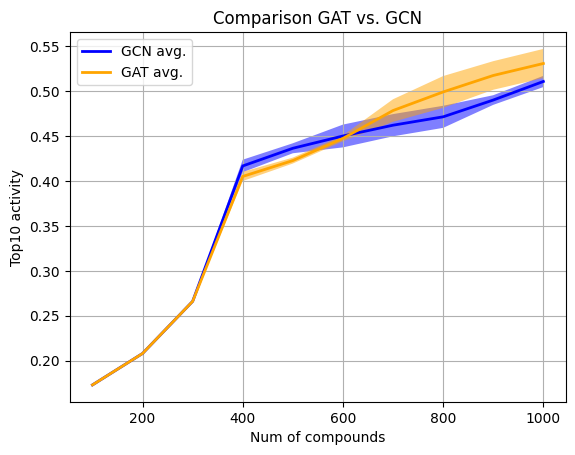

In [254]:
# 1. Initialize base loops that mutate compounds based on the input candidates
results = {'GAT': [], 'GCN': []}

for _ in range(3):
    base_loop1 = MutateLoop(
        base_dir='mlloop1',
        n_warmup_iterations=3,
        user_token=YOUR_TOKEN,
        target='GSK3β_server',
    )
    
    # 2. Initialize a GAT loop that mutates compounds
    gatloop = GNNLoop(
        base_dir="mlloop1",
        n_warmup_iterations=2,
        base_loop=base_loop1,
        user_token=YOUR_TOKEN,
        target="GSK3β_server",
        model=gat  # it will be copied, the copy will be further trained
    )
    # 3. Run the GAT loop
    gat_ml_metrics = run(gatloop, purge=True, budget=1000, steps=10)
    results['GAT'].append([m['top10'] for m in gat_ml_metrics])

    # 4. Initialize a GCN loop that mutates compounds
    base_loop2 = MutateLoop(
        base_dir='mlloop2',
        n_warmup_iterations=3,
        user_token=YOUR_TOKEN,
        target='GSK3β_server',
    )
    
    gcnloop = GNNLoop(
        base_dir="mlloop2",
        n_warmup_iterations=2,
        base_loop=base_loop2,
        user_token=YOUR_TOKEN,
        target="GSK3β_server",
        model=gcn  # it will be copied, thee further trained copy will b
    )
    # 5. Run the GCN loop
    gcn_ml_metrics = run(gcnloop, purge=True, budget=1000, steps=10)
    results['GCN'].append([m['top10'] for m in gcn_ml_metrics])

# collect statistics from n runs
gcn_mean = np.mean(results['GCN'], axis=0)
gat_mean = np.mean(results['GAT'], axis=0)
gcn_std = np.std(results['GCN'], axis=0)
gat_std = np.std(results['GAT'], axis=0)

# 6. Plot metrics using matplotlib
t = [(i+1)*100 for i in range(len(gcn_ml_metrics))]
fig, ax = plt.subplots(1)
ax.plot(t, gcn_mean, lw=2, label='GCN avg.', color='blue')
ax.plot(t, gat_mean, lw=2, label='GAT avg.', color='orange')
ax.fill_between(t, gcn_mean+gcn_std, gcn_mean-gcn_std, facecolor='blue', alpha=0.5)
ax.fill_between(t, gat_mean+gat_std, gat_mean-gat_std, facecolor='orange', alpha=0.5)
ax.set_title(r'Comparison GAT vs. GCN')
ax.legend(loc='upper left')
ax.set_xlabel('Num of compounds')
ax.set_ylabel('Top10 activity')
ax.grid()
plt.show()

# Key requirements:
* Provide results averaged over two/three sampled subsets of ZINC (set seed)
* The rest of the randomness can stay (mutation randomness etc.)
* Check different model architectures (list below)
* Use pre-trained GNN models in the ML loop (and fine-tune them on mutated compounds inside the ML loop)
* Provide a table with comparative top10 activity results

# What can be done with the architectures:

1) Use different GNN layers:
   * Overall, there's a cool [GNN cheatsheet](https://pytorch-geometric.readthedocs.io/en/2.5.0/cheatsheet/gnn_cheatsheet.html) listing the different layers and their input
   * [GCN (no edge attributes, but uses edge weights)](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html)
   * [NNConv (allows using edge attributes)](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.NNConv.html#torch_geometric.nn.conv.NNConv)
   * [GIN (no edge attributes, no edge weights, quite good)](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GINConv.html#torch_geometric.nn.conv.GINConv)
   
3) Use (or not) [batch norms 1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) or a layer pre-defined batch normalization (e.g., CGConv takes a batch_norm parameter)
4) Use different global pooling - e.g., [mean pooling](https://pytorch-geometric.readthedocs.io/en/2.5.2/generated/torch_geometric.nn.pool.global_mean_pool.html) alone or with [max pooling](https://pytorch-geometric.readthedocs.io/en/2.5.3/generated/torch_geometric.nn.pool.global_max_pool.html) concatenated etc.
5) Use dropouts or not

### Note: Random Forest will probably do better than any GNN solution (Staszek also said so)
* https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00479-8